### 기말프로젝트) 
1.고객구매데이터로 결혼여부 예측 및 RFM 분석        
1-1) 데이터
<br>

- Customers.csv : 고객정보
- Transactions.csv : 고객 구매

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#font 설정
rc('font', family='Malgun Gothic') 

#### 데이터 탐색
- 목적 : 결혼 여부 예측
- 타겟 : 결혼 여부 코드 (mrg_flg, 0:기타 1:기혼 2:미혼 7: 기타)
- 기혼 제외 모두 0으로 변경. -> 0,1 이진분류 예측, 로지스틱회귀분석도 이용.

##### raw 데이터 보기

In [4]:
#  데이터 불러오기

# 1. 고객정보 
customers = pd.read_csv('./data/Customers.csv')  

In [5]:
# 2.고객 구매데이터
Transactions = pd.read_csv('./data/Transactions.csv', parse_dates=['sales_date'])

##### 고객정보

In [362]:
customers.shape, Transactions.shape 

((49995, 11), (1726430, 11))

In [13]:
customers.info()
# 널값 없음.
# 알수없는 값까지 채워져 있음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49995 entries, 0 to 49994
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   custid     49995 non-null  int64 
 1   sex        49995 non-null  int64 
 2   birth      49995 non-null  object
 3   birth_flg  49995 non-null  int64 
 4   mrg_flg    49995 non-null  int64 
 5   h_type1    49995 non-null  object
 6   h_type2    49995 non-null  int64 
 7   hobby      49995 non-null  int64 
 8   job_stype  49995 non-null  int64 
 9   cus_stype  49995 non-null  int64 
 10  m_time1    49995 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 4.2+ MB


1) 고객 아이디 custid
2) 성별코드 sex 0: 무효, 1: 남성, 2: 여성
3) 생일 birth
4) 생일구분코드 birth_flg  -1:기타, 1:양력, 2:음력
5) 결혼여부코드 mrg_flg
6) 주거형태코드 h_type1  A 아파트, B 빌딩, H 병원, N 단독주택, V 빌라, X 기타, Z 기타(분류안됨)
7) 주거현황코드 h_type2  0 기타, 1 본인소유, 2 배우자소유, 3 부모소유, 4 전세, 5 ~ 8 기타
8) 취미코드 hobby 0001 등산 ~ 0017 기타
9) 직업코드 job_stype  
10) 고객소유형 cus_stype 1 초우량1등급 2 초우량2등급 3 초우량3등급 ~ 12 일반 2등급  (1에 가까울수록 등급 우량)
11) 주구매 시간대 m_time1 -1 알수없음, 1~48 0~24시까지 30분 간격

**데이터 분포, 상관관계 보기**

In [18]:
customers.describe()

,custid,sex,birth_flg,mrg_flg,h_type2,hobby,job_stype,cus_stype,m_time1
count,49995.000000,49995.000000,49995.000000,49995.000000,49995.000000,49995.000000,49995.000000,49995.000000,49995.000000
mean,25002.445045,1.695770,0.988419,1.261886,2.753195,13.932333,4926.448185,8.072787,30.032903
std,14433.278091,0.461128,0.961081,0.618456,1.585060,5.762665,1982.486631,2.845954,8.692864
min,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000
25%,12504.500000,1.000000,1.000000,1.000000,1.000000,17.000000,3050.000000,7.000000,27.000000
50%,25003.000000,2.000000,1.000000,1.000000,3.000000,17.000000,4660.000000,9.000000,32.000000
75%,37501.500000,2.000000,2.000000,2.000000,4.000000,17.000000,7060.000000,10.000000,36.000000
max,50000.000000,2.000000,2.000000,7.000000,8.000000,17.000000,8201.000000,12.000000,42.000000


In [84]:
cols = list(customers.columns)

for i in cols[1:]:
    data = customers[i].value_counts()
    data_df = pd.DataFrame(data)
    data_df.sort_values(i, ascending=False, inplace=True)
    print(data_df.head(),"\n")


     sex
2  34809
1  15162
0     24 

                     birth
$null$                7839
1971-05-15 00:00:00     19
1972-07-17 00:00:00     18
1975-02-10 00:00:00     17
1971-03-01 00:00:00     16 

    birth_flg
 1      27192
 2      15009
-1       7794 

   mrg_flg
1    27479
2    17801
0     4714
7        1 

   h_type1
A    28213
N    14260
V     4289
Z     3194
X       22 

   h_type2
1    13899
3    13755
4    10295
2     8320
7     3086 

    hobby
17  37832
2    4464
5    2011
3    1990
1    1277 

      job_stype
7060      16086
4200       2518
4260       1633
2810       1281
4000       1264 

    cus_stype
9       13820
8        5339
11       5003
10       4975
12       4903 

    m_time1
39     3387
38     3223
32     3107
31     3090
33     3066 



AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 

AxesSubplot(0.125,0.125;0.775x0.755) 



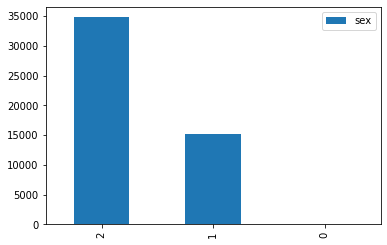

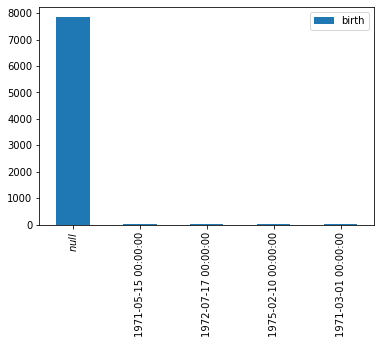

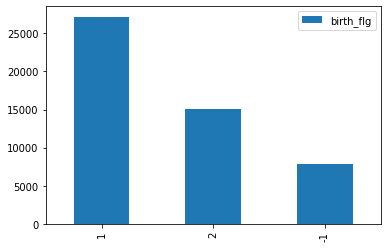

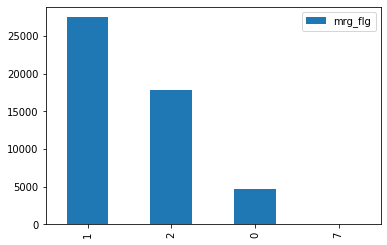

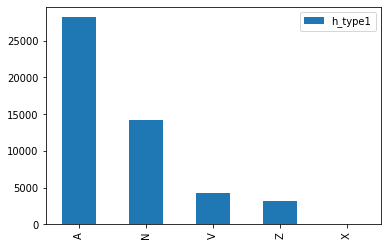

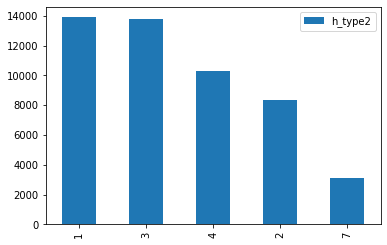

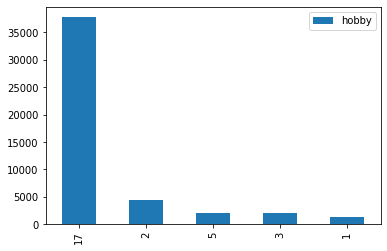

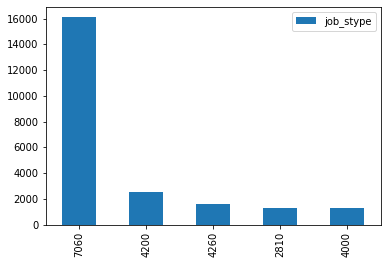

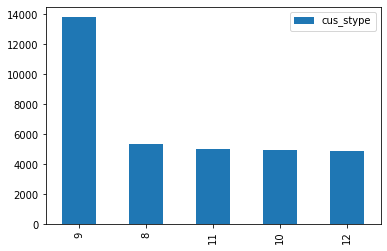

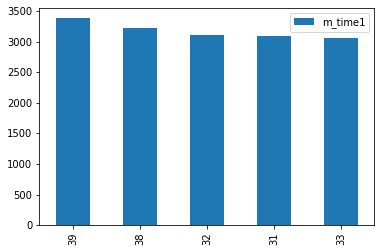

In [98]:
# 그래프로 그려서 확인하기

cols = list(customers.columns)

for i in cols[1:]:
    data = customers[i].value_counts()
    data_df = pd.DataFrame(data)
    data_df.sort_values(i, ascending=False, inplace=True)
    print(data_df.head().plot.bar(),"\n")


> 1) 성별          
> 여성 > 남성

> 2) 생일             
> null 값 많아서 삭제

> 3) 생일구분          
> 1 > 2 > -1 (양력 생일이 가장 많음)

> 4) 결혼여부          
> 1 > 2 > 0          
> - 기혼수가 가장 많음. 미혼, 기타 합칠 예정.

> 5) 주거형태              
> 아파트 > 단독주택 > 빌라 > 기타(분류안됨) > 기타 ..

> 6) 주거현황         
> 본인소유 - 부모소유 > 전세 > 배우자소유 > 기타 ..

> 7) 취미         
> 기타 > 스포츠 > 관람 > 여행 > 등산 ..          
> - 기타 제외하고 다시 보기.

> 8) 직업코드         
> 7060 > 4200 - 4260 - 2810 - 4000

> 9)  고객소유형          
> 고정 1등급(9) > 우량 4등급(8) > 일반 1등급(11) > 고정 2등급(10) > 일반 2등급(12)         
> * 1에 가까울수록 우량

> 10) 주구매 시간대          
> 19시 30분 > 19시 > 16시 > 15시 30분 > 16시 30분 ..

In [662]:
customers.head()

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
0,1,0,$null$,-1,1,A,1,17,4110,7,37,1
1,2,0,$null$,-1,1,N,1,17,7060,7,31,1
2,3,0,$null$,-1,1,A,2,17,4070,6,22,1
3,4,2,1982-09-07 00:00:00,1,2,N,4,11,4520,9,35,0
4,5,2,1982-08-17 00:00:00,1,2,Z,3,17,4520,9,-1,0


In [10]:
# customers = customers.drop('birth', axis=1)
# 생일 입력한사람 나이대 확인
# customers['birth'] = customers['birth'].replace('$null$','1901-01-01')
customers['birth'] = customers['birth'].replace('$null$', np.nan)

In [11]:
customers['birth'] = customers['birth'].replace('7978-11-27 00:00:00','1978-11-27 00:00:00')
customers['birth'] = customers['birth'].replace('9960-02-28 00:00:00','1960-02-28 00:00:00')
customers['birth'] = customers['birth'].replace('2960-01-18 00:00:00','1960-01-18 00:00:00')
customers['birth_date'] = pd.to_datetime(customers['birth'])
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49995 entries, 0 to 49994
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   custid      49995 non-null  int64         
 1   sex         49995 non-null  int64         
 2   birth       42156 non-null  object        
 3   birth_flg   49995 non-null  int64         
 4   mrg_flg     49995 non-null  int64         
 5   h_type1     49995 non-null  object        
 6   h_type2     49995 non-null  int64         
 7   hobby       49995 non-null  int64         
 8   job_stype   49995 non-null  int64         
 9   cus_stype   49995 non-null  int64         
 10  m_time1     49995 non-null  int64         
 11  mrg_flg_gb  49995 non-null  int64         
 12  birth_date  42156 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 5.0+ MB


In [697]:
customers['age'] = pd.to_datetime('2001-04-30').year - customers['birth_date'].dt.year

In [698]:
customers['age'].value_counts()

28.00    2641
29.00    2576
30.00    2489
27.00    2302
31.00    2201
         ... 
82.00       1
16.00       1
84.00       1
85.00       1
87.00       1
Name: age, Length: 87, dtype: int64

In [699]:
pdf1 = pd.pivot_table(customers,                # 피벗할 데이터프레임
                     index = 'sex',    # 행 위치에 들어갈 열
                     columns = 'age',    # 열 위치에 들어갈 열
                     values = 'custid',     # 데이터로 사용할 열
                     aggfunc = 'count')   # 데이터 집계함수
pdf1.max()  

age,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,...,82.00,83.00,84.00,85.00,87.00,88.00,90.00,94.00,95.00,101.00
sex,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN
1,NaN,1.00,4.00,4.00,NaN,1.00,3.00,1.00,1.00,NaN,...,NaN,3.00,1.00,NaN,1.00,NaN,1.00,1.00,1.00,4.00
2,8.00,12.00,24.00,8.00,6.00,3.00,NaN,NaN,1.00,1.00,...,1.00,NaN,NaN,1.00,NaN,1.00,NaN,NaN,NaN,15.00


<AxesSubplot: ylabel='Frequency'>

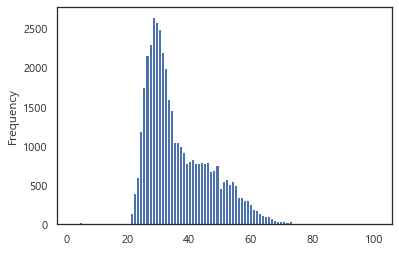

In [727]:
# 나이 분포
customers.age.plot(kind="hist", y="AGW", bins=100)

In [728]:
def age_map(x):
    if x < 20:return 1  # 10대
    elif x < 30:return 2
    elif x < 40: return 3
    elif x < 50: return 4
    elif x < 60: return 5
    else : return 6


customers['age_m'] = customers['age'].map(age_map)

In [729]:
pdf1 = pd.pivot_table(customers,                # 피벗할 데이터프레임
                     index = 'age_m',    # 행 위치에 들어갈 열
                     columns = 'mrg_flg',    # 열 위치에 들어갈 열
                     values = 'custid',     # 데이터로 사용할 열
                     aggfunc = 'count')   # 데이터 집계함수
pdf1  

mrg_flg,0,1,2,7
age_m,,,,
1,22.00,33.00,29.00,NaN
2,2054.00,1534.00,10197.00,NaN
3,1180.00,7890.00,5483.00,NaN
4,699.00,6441.00,565.00,NaN
5,397.00,3914.00,145.00,1.00
6,362.00,7667.00,1382.00,NaN


> 기혼인 사람은 3~40대와 60세 이상이 많음.

In [127]:
# 피벗테이블
# 성별 결혼여부 파악
pdf1 = pd.pivot_table(customers,                # 피벗할 데이터프레임
                     index = 'sex',    # 행 위치에 들어갈 열
                     columns = 'mrg_flg',    # 열 위치에 들어갈 열
                     values = 'custid',     # 데이터로 사용할 열
                     aggfunc = 'count')   # 데이터 집계함수
pdf1

mrg_flg,0,1,2,7
sex,,,,
0,6.0,12.0,6.0,NaN
1,917.0,11171.0,3073.0,1.0
2,3791.0,16296.0,14722.0,NaN


> 남성이면서 기혼 11171건 /15162    (0.73)                
> 여성이면서 기혼 16296건 /34809    (0.46)
> - 여성이 남성보다 기혼 비율이 낮다.
> - 여성고객은 미혼이 많고 (50%이상), 남성고객은 기혼고객이 많은 것을 알 수 있음.

In [122]:
# h_type1 주거형태
pdf2 = pd.pivot_table(customers,index = 'sex',columns = 'h_type1',values = 'custid',aggfunc = 'count')  
pdf2

h_type1,$null$,A,B,H,N,V,X,Z
sex,,,,,,,,
0,NaN,12.0,NaN,NaN,9.0,3.0,NaN,NaN
1,NaN,9844.0,6.0,NaN,3240.0,1209.0,10.0,853.0
2,1.0,18357.0,8.0,2.0,11011.0,3077.0,12.0,2341.0


> 여성중에 주거형태가 H(병원) 인 고객이 있음.                 
> 남성, 여성 모두 아파트 -> 단독주택 -> 빌라 순.

In [123]:
# h_type2 주거현황
pdf3 = pd.pivot_table(customers,index = 'sex',columns = 'h_type2',values = 'custid',aggfunc = 'count')  
pdf3

h_type2,0,1,2,3,4,5,6,7,8
sex,,,,,,,,,
0,NaN,11.0,2.0,1.0,8.0,1.0,NaN,1.0,NaN
1,58.0,7197.0,1179.0,2774.0,2997.0,174.0,59.0,697.0,27.0
2,36.0,6691.0,7139.0,10980.0,7290.0,169.0,79.0,2388.0,37.0


> 남성주거현황 본인소유             
> 여성주거현황 부모소유 > 전세 > 배우자 > 본인소유

> - 남성고객의 주거현황은 본인소유(1)가 높음.
> - 여성고객의 주거현황이 가장 높은형태는 3(부모소유)임.
> - 배우자소유(2)와 전세(4) 주거현황도 남성보다 여성이 높음.



In [135]:
pdf4 = pd.pivot_table(customers,index = 'sex',columns = 'hobby',values = 'custid',aggfunc = 'count')  
pdf4

hobby,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
sex,,,,,,,,,,,,,,,,,
0,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0
1,637.0,2132.0,548.0,236.0,473.0,43.0,26.0,1.0,6.0,NaN,33.0,2.0,20.0,191.0,125.0,6.0,10683.0
2,640.0,2329.0,1442.0,30.0,1538.0,121.0,302.0,8.0,43.0,12.0,172.0,8.0,52.0,502.0,479.0,1.0,27130.0


> 취미는 여성, 남성 기타가 가장 높음.            
> 10683건 /15162 (0.70) , 27130건 /34809 (0.77)           
> - 남성, 여성 모두 70% 이상이 취미가 기타로 의미없는 데이터라고 생각됨.

In [139]:
pdf5 = pd.pivot_table(customers,index = 'sex',columns = 'cus_stype',values = 'custid',aggfunc = 'count')  
pdf5

cus_stype,1,2,3,4,5,6,7,8,9,10,11,12
sex,,,,,,,,,,,,
0,2.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,17.0,2.0,NaN,NaN
1,691.0,535.0,1116.0,1029.0,739.0,967.0,1276.0,1687.0,3081.0,1484.0,1346.0,1211.0
2,709.0,640.0,1444.0,1544.0,1226.0,1653.0,2381.0,3652.0,10722.0,3489.0,3657.0,3692.0


> - 남성과 여성 모두 9 (고정 1등급) 유형의 고객이 많음.           
>           

In [264]:
# 고객소유형 데이터 확인
list_x = list(customers.cus_stype.value_counts().index)
list_y = list(customers.cus_stype.value_counts().values)
list_x

[9, 8, 11, 10, 12, 7, 6, 4, 3, 5, 1, 2]

In [267]:
xticks = ['고정_1등급', '우량_4등급', '일반_1등급', '고정_2등급', '일반_2등급', '우량_3등급', '우량_2등급', '초우량_4등급',
 '초우량_3등급', '우량_1등급', '초우량_1등급', '초우량_2등급']

In [268]:
dict_result = dict(zip(xticks, list_y))

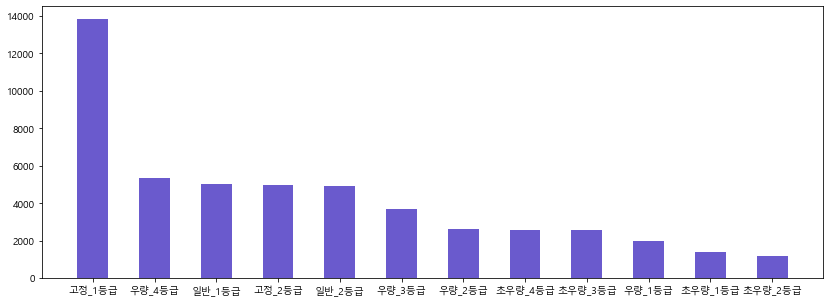

In [269]:
plt.figure(figsize=(14, 5))
plt.bar(dict_result.keys(), dict_result.values(), color='slateblue', width=0.5)
plt.xticks(list(dict_result.keys()))
plt.show()

> - 앞에서 살펴봤던 것과 같이 고정 1등급의 고객이 가장 많음.

In [279]:
dict1 = dict(zip(list_x, xticks))
print(dict1)

{9: '고정_1등급', 8: '우량_4등급', 11: '일반_1등급', 10: '고정_2등급', 12: '일반_2등급', 7: '우량_3등급', 6: '우량_2등급', 4: '초우량_4등급', 3: '초우량_3등급', 5: '우량_1등급', 1: '초우량_1등급', 2: '초우량_2등급'}


In [282]:
li = list(customers.query("sex == 1").cus_stype.value_counts().index)
m_list_x = []
for i in li:
    a = dict1.get(i)
    m_list_x.append(a)

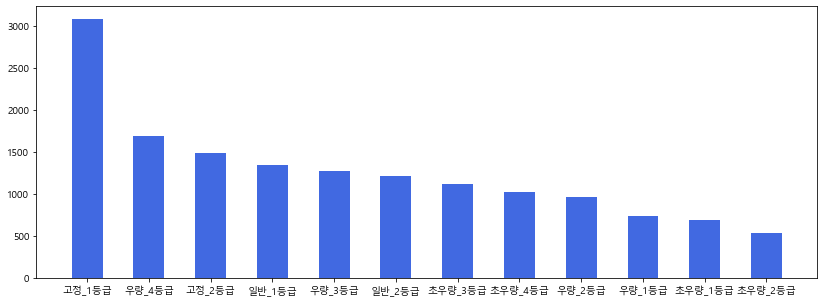

In [289]:
list_x = m_list_x
list_y = list(customers.query("sex == 1").cus_stype.value_counts().values)

plt.figure(figsize=(14, 5))
plt.bar(list_x, list_y, color='royalblue', width=0.5)
plt.show()

In [357]:
# 남자 등급 비율
s = customers.query("sex == 1").cus_stype.value_counts().sum()
data_y = list(((customers.query("sex == 1").cus_stype.value_counts()/s).round(2)).values)
data_x = list(((customers.query("sex == 1").cus_stype.value_counts()/s)).index)
m_list_x = []
for i in data_x:
    a = dict1.get(i)
    m_list_x.append(a)


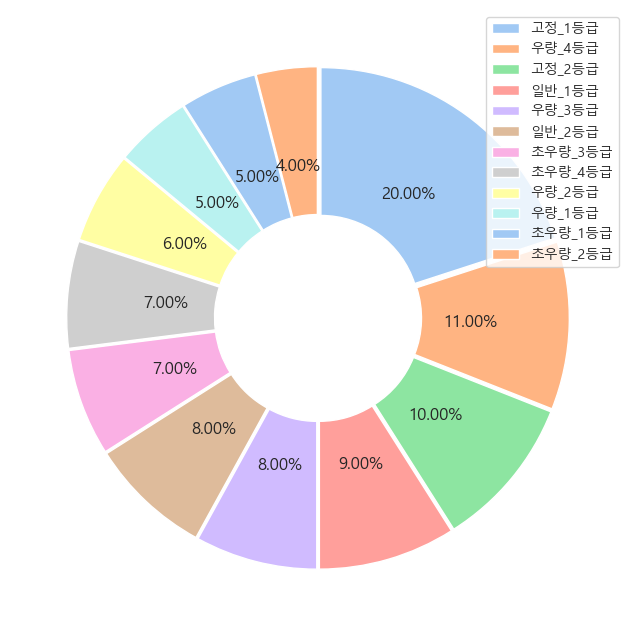

In [359]:
## 데이터 준비
labels = m_list_x ## 라벨
per = data_y ## 빈도

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임 생성
 
pie = ax.pie(per, ## 파이차트 출력
       startangle=90, ## 시작점을 90도(degree)로 지정
       counterclock=False, ## 시계 방향으로 그린다.
       autopct=lambda p : '{:.2f}%'.format(p), ## 퍼센티지 출력
       wedgeprops=dict(width=0.6), ## 중간의 반지름 0.6만큼 구멍을 뚫어준다.
       explode=[ 0.02 for num in labels ]
       )
 
plt.legend(pie[0],labels, fontsize=10) ## 범례 표시
plt.show()

> - 남성은 고정 1등급 다음으로 우량 4등급의 고객이 많음.

In [287]:
li = list(customers.query("sex == 2").cus_stype.value_counts().index)
w_list_x = []
for i in li:
    b = dict1.get(i)
    w_list_x.append(b)

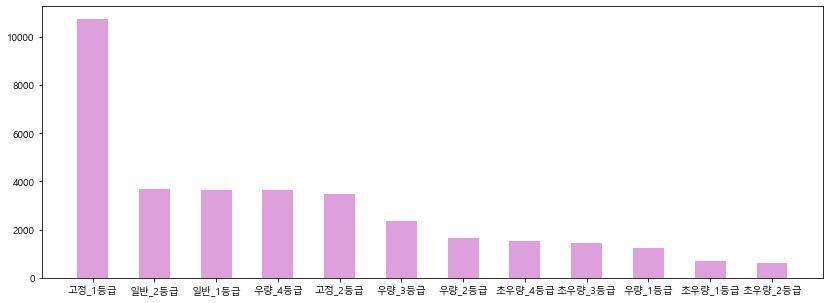

In [290]:
list_x = w_list_x
list_y = list(customers.query("sex == 2").cus_stype.value_counts().values)
dict_result = dict(zip(xticks, list_y))

plt.figure(figsize=(14, 5))
plt.bar(list_x, list_y, color='plum', width=0.5)
plt.show()

In [320]:
s = customers.query("sex == 2").cus_stype.value_counts().sum()
data_y = list(((customers.query("sex == 2").cus_stype.value_counts()/s).round(2)).values)
data_x = list(((customers.query("sex == 2").cus_stype.value_counts()/s)).index)
w_list_x = []
for i in data_x:
    b = dict1.get(i)
    w_list_x.append(b)

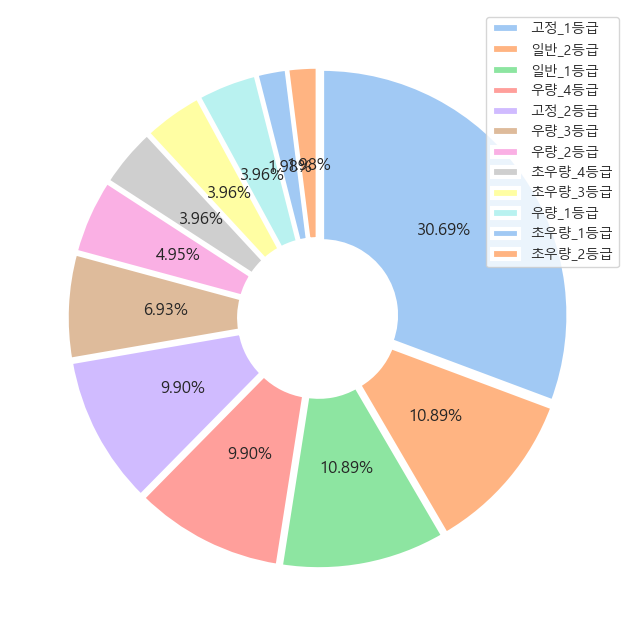

In [356]:
sns.set(style='whitegrid')
sns.set_palette('pastel')
rc('font', family='Malgun Gothic') 

labels = w_list_x ## 라벨
per = data_y ## 빈도

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white') 
ax = fig.add_subplot() 

pie = ax.pie(per,counterclock=False,explode=[ 0.02 for num in labels ],
startangle=90, autopct='%.2f%%',wedgeprops = {'width':0.7,'edgecolor':'w','linewidth':3})

plt.legend(pie[0],labels, fontsize=10) ## 범례 표시
plt.show()

> - 여성은 고정1등급 다음으로 일반 2등급, 일반 1등급 의 고객이 많음.

In [244]:
# 구매시간대 살펴보기
df_m_time = pd.DataFrame(customers.m_time1.value_counts()).sort_index().reset_index()
df_m_time.columns = ['m_time1', 'cnt']
df_m_time.head()

,m_time1,cnt
0,-1,2572
1,19,4
2,20,6
3,21,14
4,22,582


In [245]:
df_m_time['rel_freq'] = (df_m_time['cnt'] / df_m_time['cnt'].sum())

In [219]:
df_m_time

,m_time1,cnt,rel_freq
0,-1,2572,0.051445
1,19,4,0.000080
2,20,6,0.000120
3,21,14,0.000280
4,22,582,0.011641
5,23,1682,0.033643
6,24,2175,0.043504
7,25,2239,0.044784
8,26,2441,0.048825
9,27,2367,0.047345


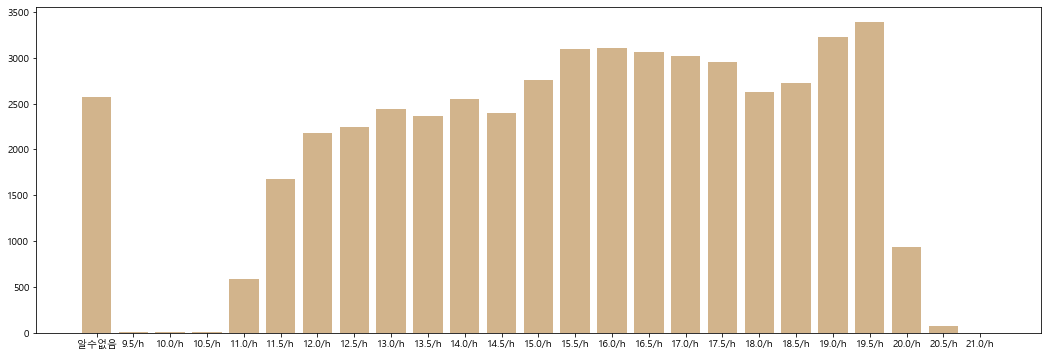

In [248]:
time_idx = (df_m_time.m_time1/2).astype(str) + '/h'
time_idx[0] = '알수없음'

plt.figure(figsize=(18, 6))
plt.bar(time_idx, df_m_time.cnt, color='tan')
plt.show()

> - 구매시간대 오후 - 유독 집중되는 시간대는 없음.            
> - 그래도 가장 높은 구매시간대 39로, 오후 7시 30분                
> - 9시반부터 조금씩 있지만, 주구매 시간대는 11시 부터 시작됨을 알 수 있음.               
> - 오후 8시 이후로 주구매 고객이 줄어들면서 8시 30분 이후로는 거의 없음.

In [238]:
# 남성 구매시간대
m_df = customers.query("sex == 1")
m_df.sex.value_counts()

1    15162
Name: sex, dtype: int64

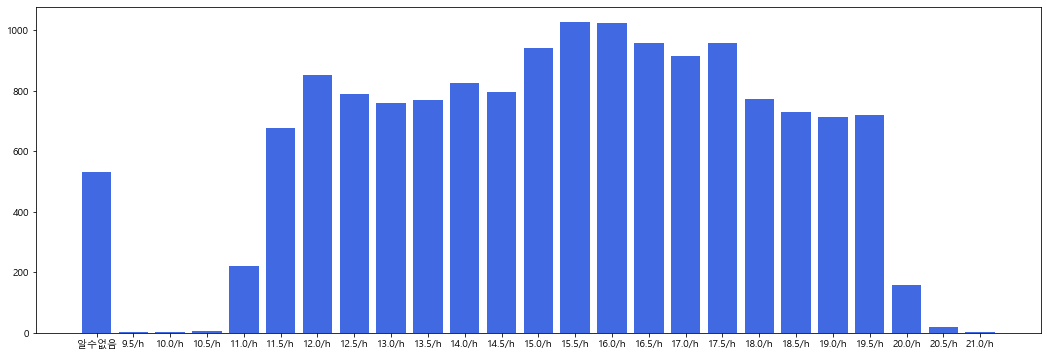

In [249]:
df_m_time = pd.DataFrame(m_df.m_time1.value_counts()).sort_index().reset_index()
df_m_time.columns = ['m_time1', 'cnt']
time_idx = (df_m_time.m_time1/2).astype(str) + '/h'
time_idx[0] = '알수없음'

plt.figure(figsize=(18, 6))
plt.bar(time_idx, df_m_time.cnt, color='royalblue')
plt.show()

> - 남성의 경우 오후 3시 반에서 4시가 주구매 시간인 고객이 높음. 

In [239]:
# 여성 구매시간대
w_df = customers.query("sex == 2")

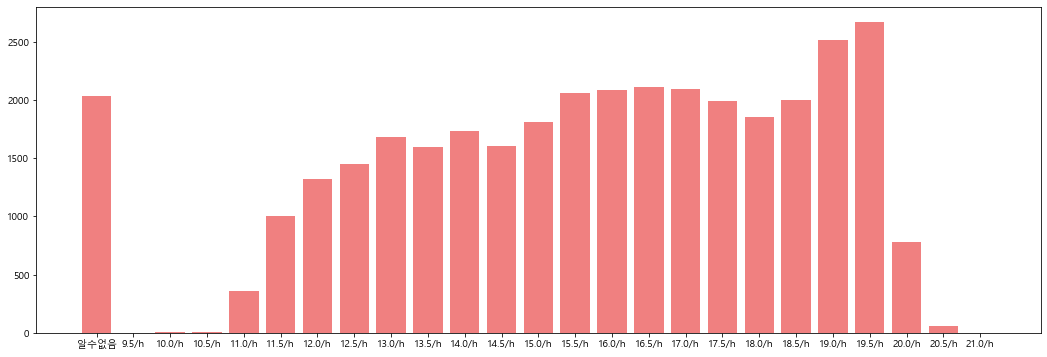

In [250]:
df_m_time = pd.DataFrame(w_df.m_time1.value_counts()).sort_index().reset_index()
df_m_time.columns = ['m_time1', 'cnt']
time_idx = (df_m_time.m_time1/2).astype(str) + '/h'
time_idx[0] = '알수없음'

plt.figure(figsize=(18, 6))
plt.bar(time_idx, df_m_time.cnt, color='lightcoral')
plt.show()

> - 여성고객인 경우 주구매시간대는 오후 7시와 7시 30분인 경우가 많음.

In [20]:
customers.corr() 

,custid,sex,birth_flg,mrg_flg,h_type2,hobby,job_stype,cus_stype,m_time1
custid,1.000000,-0.286721,-0.260718,-0.400672,-0.427608,-0.032171,0.023827,-0.281173,0.025436
sex,-0.286721,1.000000,0.200387,0.127741,0.152378,0.105169,0.185350,0.142359,0.012512
birth_flg,-0.260718,0.200387,1.000000,0.039394,0.188488,0.081202,0.178989,0.175856,-0.000680
mrg_flg,-0.400672,0.127741,0.039394,1.000000,0.164367,-0.060036,-0.135589,0.098586,0.027470
h_type2,-0.427608,0.152378,0.188488,0.164367,1.000000,0.034291,-0.002862,0.159798,0.003674
hobby,-0.032171,0.105169,0.081202,-0.060036,0.034291,1.000000,0.073240,0.020388,-0.015907
job_stype,0.023827,0.185350,0.178989,-0.135589,-0.002862,0.073240,1.000000,0.036475,-0.008995
cus_stype,-0.281173,0.142359,0.175856,0.098586,0.159798,0.020388,0.036475,1.000000,-0.080393
m_time1,0.025436,0.012512,-0.000680,0.027470,0.003674,-0.015907,-0.008995,-0.080393,1.000000


In [21]:
corr_df = customers.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,custid,sex,birth_flg,mrg_flg,h_type2,hobby,job_stype,cus_stype,m_time1
custid,1.00,-0.29,-0.26,-0.40,-0.43,-0.03,0.02,-0.28,0.03
sex,-0.29,1.00,0.20,0.13,0.15,0.11,0.19,0.14,0.01
birth_flg,-0.26,0.20,1.00,0.04,0.19,0.08,0.18,0.18,-0.00
mrg_flg,-0.40,0.13,0.04,1.00,0.16,-0.06,-0.14,0.10,0.03
h_type2,-0.43,0.15,0.19,0.16,1.00,0.03,-0.00,0.16,0.00
hobby,-0.03,0.11,0.08,-0.06,0.03,1.00,0.07,0.02,-0.02
job_stype,0.02,0.19,0.18,-0.14,-0.00,0.07,1.00,0.04,-0.01
cus_stype,-0.28,0.14,0.18,0.10,0.16,0.02,0.04,1.00,-0.08
m_time1,0.03,0.01,-0.00,0.03,0.00,-0.02,-0.01,-0.08,1.00


In [22]:
s = corr_df.unstack()
s

custid   custid       1.00
         sex         -0.29
         birth_flg   -0.26
         mrg_flg     -0.40
         h_type2     -0.43
                      ... 
m_time1  h_type2      0.00
         hobby       -0.02
         job_stype   -0.01
         cus_stype   -0.08
         m_time1      1.00
Length: 81, dtype: float64

In [25]:
# !pip install Jinja2

     -------------------------------------- 133.1/133.1 kB 4.0 MB/s eta 0:00:00


In [32]:
# Series이므로 DataFrame으로 변경한다. 
df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.head(8).style.background_gradient(cmap='viridis')

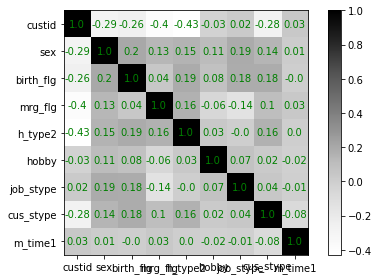

In [29]:
# Heatmap 데이터 시각화

fig, ax = plt.subplots()
im = ax.imshow(corr_df, cmap='Greys')

# Color Bar
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))

ax.set_xticklabels(corr_df.columns)
ax.set_yticklabels(corr_df.columns)

for x in range(len(corr_df.columns)):
    for y in range(len(corr_df.index)):
        ax.text(y, x, corr_df.iloc[y, x], ha='center', va='center', color='g')

fig.tight_layout()   
plt.show()    

> 1. 가장 상관계수가 높은 값은 0.2으로 상관관계가 낮으며, 변수쌍은 sex - birth_flg 이다.

##### 고객구매 데이터

In [373]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726430 entries, 0 to 1726429
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   sales_date  datetime64[ns]
 1   custid      int64         
 2   goodcd      int64         
 3   brd_nm      object        
 4   team_nm     object        
 5   part_nm     object        
 6   pc_nm       object        
 7   corner_nm   object        
 8   tot_amt     int64         
 9   dis_amt     int64         
 10  net_amt     int64         
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 144.9+ MB


In [374]:
Transactions.head()

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt
0,2000-05-01,7595,2700000000000,식품,식품팀,공산품,일반식품,주류,28000,0,28000
1,2000-05-01,36860,2700000000000,식품,식품팀,공산품파트,일반식품,차류,59700,0,59700
2,2000-05-01,48385,4125270007985,슈프리미아,잡화가용팀,잡화파트,장신구,화장잡화,17000,0,17000
3,2000-05-01,29611,4508720043900,삼운/브로니,잡화가용팀,가정용품,식기,욕실용품,14000,700,13300
4,2000-05-01,16457,4120441805900,베네통토탈,의류패션팀,영플라자,소품,피혁토탈(B2),5800,290,5510


In [30]:
Transactions['year'] = Transactions.sales_date.dt.year
Transactions['month'] = Transactions.sales_date.dt.month
Transactions['day'] = Transactions.sales_date.dt.day

In [376]:
Transactions.head()

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
0,2000-05-01,7595,2700000000000,식품,식품팀,공산품,일반식품,주류,28000,0,28000,2000,5,1
1,2000-05-01,36860,2700000000000,식품,식품팀,공산품파트,일반식품,차류,59700,0,59700,2000,5,1
2,2000-05-01,48385,4125270007985,슈프리미아,잡화가용팀,잡화파트,장신구,화장잡화,17000,0,17000,2000,5,1
3,2000-05-01,29611,4508720043900,삼운/브로니,잡화가용팀,가정용품,식기,욕실용품,14000,700,13300,2000,5,1
4,2000-05-01,16457,4120441805900,베네통토탈,의류패션팀,영플라자,소품,피혁토탈(B2),5800,290,5510,2000,5,1


In [761]:
# 년 - 월 - 구매고객 수 (count)
pdf1 = pd.pivot_table(Transactions,index = ['year','month'],values = 'custid', aggfunc = 'count') 
pdf1['per'] = (pdf1['custid']/pdf1['custid'].sum()) * 100

In [762]:
pdf1.sort_values(by='per', ascending=False)

custid   per
year month              
2001 4      176884 10.25
2000 7      167403  9.70
     6      163624  9.48
     10     160938  9.32
     12     148955  8.63
     5      144474  8.37
2001 3      136763  7.92
     1      135967  7.88
2000 9      133188  7.71
     11     124906  7.23
     8      118948  6.89
2001 2      114380  6.63

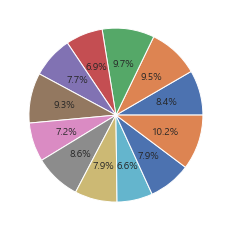

In [763]:
plt.pie(pdf1['per'], autopct='%.1f%%')
plt.show()

> 가장 많이 구매가 이루어진 달은 2001년 4월 

In [385]:
# 년 - 월 - 최대 구매금액 (max)
pdf1 = pd.pivot_table(Transactions,index = ['year','month'],values = 'tot_amt', aggfunc = 'max') 
pdf1  

tot_amt
year month          
2000 5      35650000
     6      33620000
     7      30820000
     8      19587000
     9      72000000
     10     29000000
     11     12460000
     12     21240000
2001 1      17740000
     2      13176000
     3      26300000
     4      27327500

In [390]:
Transactions.query("tot_amt == 72000000")

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
723344,2000-09-30,32532,6124240019900,까르띠에본점,잡화가용팀,잡화파트,명품토탈,수입의류,72000000,0,72000000,2000,9,30


> 72000000, 2000년 9월 고객 구매가격 최대값 가장높은 달.                    
> 수입의류 까르띠에 에서 명품구매        

In [391]:
# 년 - 월 - 최소 구매금액 (min)
pdf1 = pd.pivot_table(Transactions,index = ['year','month'],values = 'tot_amt', aggfunc = 'min') 
pdf1  

tot_amt
year month          
2000 5     -12640000
     6     -10680000
     7     -30820000
     8     -19587000
     9     -12460000
     10    -72000000
     11    -12460000
     12    -12460000
2001 1     -14790000
     2     -13176000
     3     -10525000
     4     -10750000

In [393]:
Transactions.query("tot_amt == -72000000")

,sales_date,custid,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
738145,2000-10-02,32532,6124240006900,까르띠에본점,잡화가용팀,잡화파트,명품토탈,수입의류,-72000000,0,-72000000,2000,10,2


> - 금액이면 환불로 예측.             
> 까르띠에 명품의류에서 구매 2000년 9월 30일 구매하여 10월 2일에 환불한 것을 알 수 있음.

In [394]:
#  '-' 금액 제외하고 평균구매금액 확인
t_df = Transactions.query("tot_amt > 0")
pdf1 = pd.pivot_table(t_df,index = ['year','month'],values = 'tot_amt', aggfunc = 'mean') 
pdf1  

tot_amt
year month               
2000 5      110156.644118
     6      115647.147160
     7      103842.508188
     8      113314.186688
     9      126845.170667
     10     132423.497268
     11     148456.267724
     12     130799.424244
2001 1      130736.256170
     2      120469.290995
     3      123223.733563
     4      122146.681513

> - 평균구매금액은 10만원 ~ 12만원            
> - 평균구매금액 가장높은달은 2000년 11월으로 약 15만원

In [395]:
#평균 환불금액
t_df = Transactions.query("tot_amt < 0")
pdf1 = pd.pivot_table(t_df,index = ['year','month'],values = 'tot_amt', aggfunc = 'mean') 
pdf1  

tot_amt
year month               
2000 5     -190543.170375
     6     -197989.810245
     7     -177137.929530
     8     -223326.534427
     9     -225035.947777
     10    -269217.176795
     11    -312710.246517
     12    -267680.261275
2001 1     -262850.421058
     2     -269307.494666
     3     -233051.305840
     4     -230154.890033

In [403]:
(t_df.shape[0]/Transactions.shape[0])*100

6.715650214604704

> - 환불금액 가장 많은 달은 11월 약 30만원.           
> - 전체 구매데이터중에 환불정보 약 6% .       
> 환불 많지 않은데, 환불 비용 높다. 높은 가격의 상품이 환불됨을 알 수 있음.          

In [421]:
Transactions.columns[2:8]

Index(['goodcd', 'brd_nm', 'team_nm', 'part_nm', 'pc_nm', 'corner_nm'], dtype='object')

In [422]:
for i in list(Transactions.columns[2:8]):
    cnt = len(Transactions[i].unique())
    print(f'{i} unique 수 : ', cnt)

goodcd unique 수 :  11031
brd_nm unique 수 :  1906
team_nm unique 수 :  5
part_nm unique 수 :  31
pc_nm unique 수 :  78
corner_nm unique 수 :  309


> - 상품코드는 만개가 넘고 브랜드 코드는 1906개.
> - 팀은 5곳, 파트구분 31개.         

In [416]:
Transactions.team_nm.unique()

array(['식품팀', '잡화가용팀', '의류패션팀', '상품개발영업2과', '인터넷백화점'], dtype=object)

In [426]:
# 구매정보 많은 팀 확인
pdf1 = pd.pivot_table(t_df,index ='team_nm',values = ['custid', 'tot_amt'], aggfunc = {'custid':'count', 'tot_amt':'mean'}) 
pdf1  

,custid,tot_amt
team_nm,,
상품개발영업2과,1,-39000.000000
식품팀,2946,-98852.083503
의류패션팀,59796,-262592.662753
잡화가용팀,53198,-213621.572089


In [427]:
# 환불이 많이 일어나는 팀 확인
t_df = Transactions.query("tot_amt < 0")
pdf1 = pd.pivot_table(t_df,index ='team_nm',values = 'tot_amt', aggfunc = ['mean','max','min']) 
pdf1  

,mean,max,min
,tot_amt,tot_amt,tot_amt
team_nm,,,
상품개발영업2과,-39000.000000,-39000,-39000
식품팀,-98852.083503,-952,-11628000
의류패션팀,-262592.662753,-50,-19587000
잡화가용팀,-213621.572089,-64,-72000000


In [428]:
# 구매액 높은 팀
t_df = Transactions.query("tot_amt > 0")
pdf1 = pd.pivot_table(t_df,index ='team_nm',values = 'tot_amt', aggfunc = ['mean','max','min']) 
pdf1  

,mean,max,min
,tot_amt,tot_amt,tot_amt
team_nm,,,
상품개발영업2과,57333.333333,94000,39000
식품팀,42328.698959,17740000,270
의류패션팀,175725.604007,19746000,50
인터넷백화점,85000.000000,85000,85000
잡화가용팀,128056.296276,72000000,64


In [429]:
Transactions.part_nm.unique()

array(['공산품', '공산품파트', '잡화파트', '가정용품', '영플라자', '생식품', '명품잡화', '아동,스포츠',
       '남성의류', '생식품파트', '영캐릭터', '로얄부띠끄', '케주얼,구두,아동', '아동문화', '스포츠캐주얼',
       '아동', '패션잡화', '골프/유니캐쥬얼', '가정용품파트', '여성캐쥬얼', '영어덜트캐쥬얼', '여성의류파트',
       '남성정장스포츠', '여성캐주얼', '잡화', '여성정장', '스포츠캐쥬얼', '로얄부틱', '영라이브',
       '상품개발영업1과', '인터넷백화점'], dtype=object)

In [432]:
# 구매가 많은 파트 확인
pdf1 = pd.pivot_table(t_df,index ='part_nm',values = ['custid', 'tot_amt'], aggfunc = {'custid':'count', 'tot_amt':'mean'})
pdf1.sort_values(by='tot_amt', ascending = False).head()  

,custid,tot_amt
part_nm,,
로얄부띠끄,15720,583137.080153
로얄부틱,5909,383837.072263
여성정장,36102,367023.461027
여성의류파트,31089,353763.724372
남성정장스포츠,39713,214947.180520


In [433]:
pdf1.sort_values(by='custid', ascending = False).head() 

,custid,tot_amt
part_nm,,
공산품,155852,34677.180402
명품잡화,124455,136990.845968
잡화파트,115912,159231.936624
"케주얼,구두,아동",109456,100275.363580
생식품,105445,47057.507013


> 구매액 높은 파트 top 5 - 로얄부띠끄, 로얄부틱, 여성정상, 여성의류, 남성정장스포츠         
> 구매수 높은 파트 top 5 - 공산품, 명품잡화, 잡화파트, 캐주얼/구두/아동, 생식품 

In [454]:
# 환불 크게 일어나는 파트
t_df = Transactions.query("tot_amt < 0")
pdf1 = pd.pivot_table(t_df,index ='part_nm',values = 'tot_amt', aggfunc = ['mean','max','min']) 
pdf1 = pdf1.droplevel(axis=1,level=1)
pdf1.sort_values(by='mean').head()


,mean,max,min
part_nm,,,
로얄부띠끄,-786731.005291,-2000,-19587000
여성정장,-542295.985891,-500,-13176000
로얄부틱,-501000.798403,-10000,-6240000
여성의류파트,-494661.935555,-7000,-13200000
가정용품,-366834.900254,-2520,-10750000


In [439]:
pdf1 = pd.pivot_table(t_df,index ='part_nm',values = 'custid', aggfunc = 'count') 
pdf1.sort_values(by='custid',ascending=False).head()

,custid
part_nm,
"케주얼,구두,아동",10398
여성캐주얼,8272
잡화파트,8223
명품잡화,8070
영플라자,5734


> - 환불 크게 일어나는 파트 로얄부띠끄.
> - 여성정장에서도 환불 많이 일어남.
> - 환불 많이 일어나는 top 5 - 파트 캐주얼/구두/아동, 여성캐주얼, 잡화파트, 명품잡화, 영플라자 

In [16]:
# 할인액 
# 어느 파트에서 할인이 많이될까?
t_df = Transactions.query("tot_amt > 0")   # 환불아닌 것
pdf1 = pd.pivot_table(t_df,index ='part_nm',values = 'dis_amt', aggfunc = 'mean') 
pdf1.sort_values(by='dis_amt',ascending=False).head(10)

,dis_amt
part_nm,
로얄부띠끄,23614.347964
여성의류파트,16717.892502
여성정장,14732.594039
로얄부틱,12796.354713
여성캐주얼,7907.051680
남성정장스포츠,7903.656737
영캐릭터,7350.163278
여성캐쥬얼,7214.130377
영어덜트캐쥬얼,6136.981273


> - 평균 할인액 로얄부띠끄가 가장 높음.
> - 상위 다섯개 항목 여성들이 많이 찾는 파트코드가 주를 이룸.
> - 여성들이 할인에 더 신경쓰는 것을 알 수 있음.

In [18]:
t_df = Transactions.query("tot_amt > 0")   # 환불아닌 것
pdf1 = pd.pivot_table(t_df,index ='brd_nm',values = 'dis_amt', aggfunc = 'mean') 
pdf1.sort_values(by='dis_amt',ascending=False).head(10)

,dis_amt
brd_nm,
툰투리,298018.333333
비취옥방,171424.285714
진도모피,161085.315615
성진모피,112766.771654
압소바직배,106218.000000
근화모피,104398.523002
이광희,96683.578431
엘르뿌뽕직배,89350.000000
흙침대,66461.290323


> - 툰투리 라는 브랜드가 평균 할인액이 가장 높음.            
( 툰두리 : 헬스싸이클,런닝머신 - 가격대가 높아서 할인액도 높은 것으로 예상됨) 

##### 타겟변수생성

In [6]:
# 타겟변수 mrg_flg

customers.mrg_flg.value_counts()
# 기혼 : 24,479, 미혼 + 기타 : 22,516

1    27479
2    17801
0     4714
7        1
Name: mrg_flg, dtype: int64

In [7]:
def target_binary(x):
    if x == 1: return x
    else: return 0

customers['mrg_flg_gb'] = customers.mrg_flg.map(target_binary)

In [732]:
customers.mrg_flg_gb.value_counts()

1    27479
0    22516
Name: mrg_flg_gb, dtype: int64

##### 데이터 합쳐보기

In [8]:
df_m = pd.merge(customers,Transactions, how='left', on=['custid'])
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1726430 entries, 0 to 1726429
Data columns (total 22 columns):
 #   Column      Dtype         
---  ------      -----         
 0   custid      int64         
 1   sex         int64         
 2   birth       object        
 3   birth_flg   int64         
 4   mrg_flg     int64         
 5   h_type1     object        
 6   h_type2     int64         
 7   hobby       int64         
 8   job_stype   int64         
 9   cus_stype   int64         
 10  m_time1     int64         
 11  mrg_flg_gb  int64         
 12  sales_date  datetime64[ns]
 13  goodcd      int64         
 14  brd_nm      object        
 15  team_nm     object        
 16  part_nm     object        
 17  pc_nm       object        
 18  corner_nm   object        
 19  tot_amt     int64         
 20  dis_amt     int64         
 21  net_amt     int64         
dtypes: datetime64[ns](1), int64(14), object(7)
memory usage: 302.9+ MB


In [32]:
df_m.head()

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
0,1,0,$null$,-1,1,A,1,17,4110,7,...,식품팀,생식품파트,일반식품,냉장식품,49790,0,49790,2000,5,4
1,1,0,$null$,-1,1,A,1,17,4110,7,...,식품팀,생식품파트,농산물,곡물,29100,0,29100,2000,5,4
2,1,0,$null$,-1,1,A,1,17,4110,7,...,식품팀,공산품파트,일반식품,인스탄트식품,49360,0,49360,2000,5,8
3,1,0,$null$,-1,1,A,1,17,4110,7,...,의류패션팀,"케주얼,구두,아동",아동복,유아복,42500,2130,40370,2000,5,8
4,1,0,$null$,-1,1,A,1,17,4110,7,...,의류패션팀,"케주얼,구두,아동",아동복,유아복,93400,4670,88730,2000,5,8


In [734]:
df_m.columns

Index(['custid', 'sex', 'birth', 'birth_flg', 'mrg_flg', 'h_type1', 'h_type2',
       'hobby', 'job_stype', 'cus_stype', 'm_time1', 'birth_date', 'age',
       'age_m', 'mrg_flg_gb', 'sales_date', 'goodcd', 'brd_nm', 'team_nm',
       'part_nm', 'pc_nm', 'corner_nm', 'tot_amt', 'dis_amt', 'net_amt',
       'year', 'month', 'day'],
      dtype='object')

**나이대별 구매액 및 선호상품**

In [738]:
data = df_m.groupby(["age_m"])['tot_amt','dis_amt','net_amt'].mean()
data = pd.DataFrame(data)
data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\546905137.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = df_m.groupby(["age_m"])['tot_amt','dis_amt','net_amt'].mean()


,tot_amt,dis_amt,net_amt
age_m,,,
1,88953.96,2994.46,85959.50
2,86490.68,3439.32,83051.36
3,89682.61,3076.21,86606.41
4,98704.50,2974.78,95729.72
5,109571.21,3360.81,106210.40


<AxesSubplot: title={'center': '60세이상 실구매액 top10 브랜드'}, xlabel='brd_nm'>

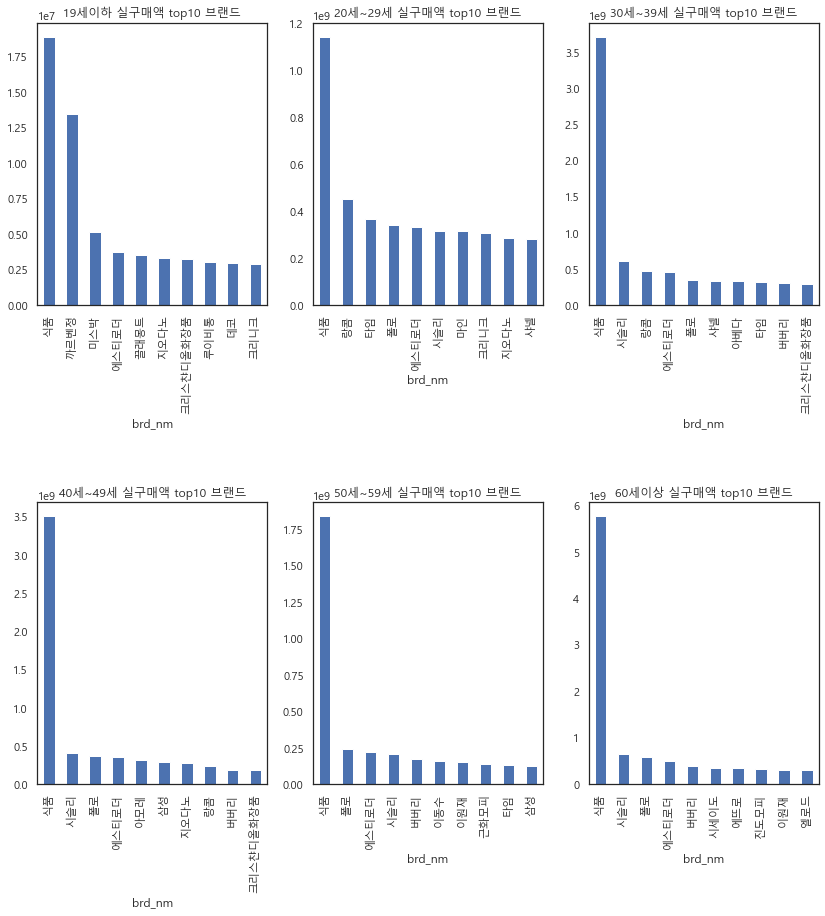

In [747]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=3)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

#  Age = ['19세이하','20세~29세', '30세~39세','40세~49세','50세~59세','60세이상']
df_m.query('age_m==1').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][0],title="19세이하 실구매액 top10 브랜드")
df_m.query('age_m==2').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][1],title="20세~29세 실구매액 top10 브랜드")
df_m.query('age_m==3').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][2],title="30세~39세 실구매액 top10 브랜드")
df_m.query('age_m==4').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][0],title="40세~49세 실구매액 top10 브랜드")
df_m.query('age_m==5').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][1],title="50세~59세 실구매액 top10 브랜드")
df_m.query('age_m==6').groupby('brd_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][2],title="60세이상 실구매액 top10 브랜드")

<AxesSubplot: title={'center': '60세이상 실구매액 파트코드'}, xlabel='part_nm'>

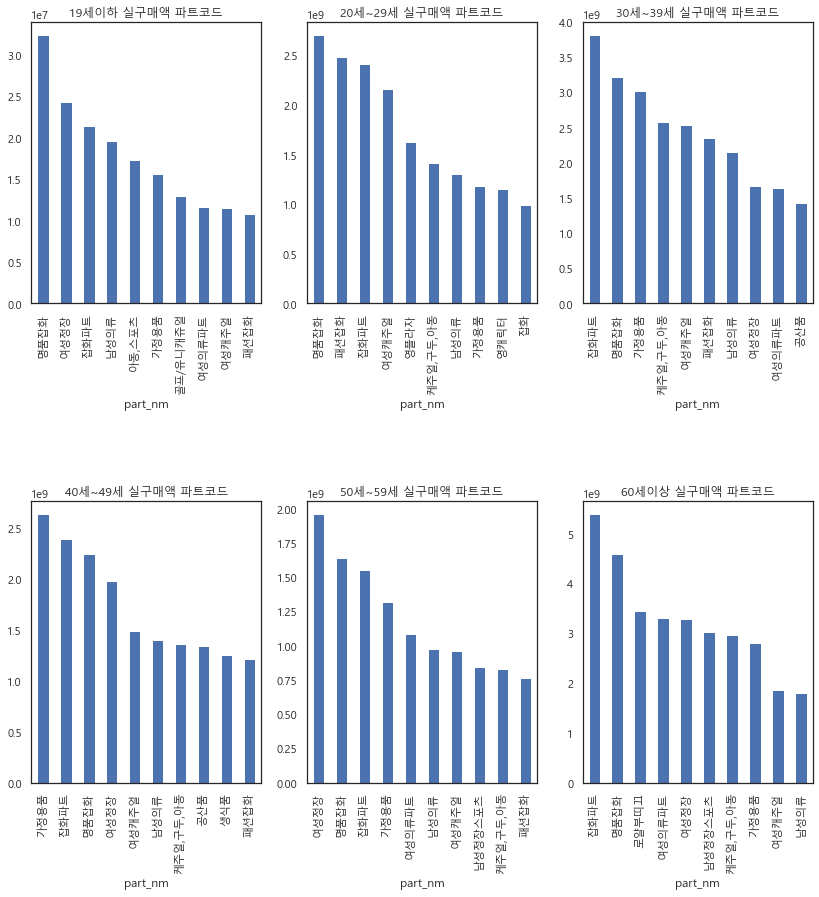

In [764]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=3)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

#  Age = ['19세이하','20세~29세', '30세~39세','40세~49세','50세~59세','60세이상']
df_m.query('age_m==1').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][0],title="19세이하 실구매액 파트코드")
df_m.query('age_m==2').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][1],title="20세~29세 실구매액 파트코드")
df_m.query('age_m==3').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[0][2],title="30세~39세 실구매액 파트코드")
df_m.query('age_m==4').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][0],title="40세~49세 실구매액 파트코드")
df_m.query('age_m==5').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][1],title="50세~59세 실구매액 파트코드")
df_m.query('age_m==6').groupby('part_nm')['net_amt'].sum().sort_values(ascending=False)[:10].plot(kind='bar',ax=axs[1][2],title="60세이상 실구매액 파트코드")

**구매액/할인액/실구매액 - 월별, 파트별**

In [82]:
# 고객별  평균 구매액, 할인액, 실구매액 확인
data1 = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].mean()
data1 = pd.DataFrame(data1)
data1.head()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\3166881847.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].mean()


,tot_amt,dis_amt,net_amt
custid,,,
1,49356.90,546.75,48810.14
2,76154.61,2541.07,73613.54
3,95465.28,964.56,94500.72
4,68233.33,4683.33,63550.00
5,43250.00,4325.00,38925.00


In [83]:
data1.dis_amt.sort_values(ascending=False).head()

custid
19972   152875.00
30231   118150.00
29469   100321.43
45526    94644.44
14559    83752.63
Name: dis_amt, dtype: float64

In [65]:
customers.query("custid == 19972")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
19966,19972,1,1969-07-10 00:00:00,2,2,A,3,17,1180,2,36,0


In [66]:
customers.query("custid == 30231")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
30225,30231,1,1961-10-13 00:00:00,2,0,A,1,17,7130,9,-1,0


> 할인액 가장 높은 고객은 19972 으로, 평균 할인액이 15만원인 것으로 보임.           
> 96년생 남성, 부모소유 아파트 주거 미혼으로 고객 - 초우량 2등급 유형         

> 두번째 할인액 높은 고객은 61년생 남성, 본인소유 아파트 거주. 고정 1등급 고객.

In [84]:
# 1년동안의 고객 구매액, 할인액, 실구매액 합계
data1 = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()
data1 = pd.DataFrame(data1)
data1.head()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\2416997840.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()


,tot_amt,dis_amt,net_amt
custid,,,
1,3800481,42100,3758381
2,2132329,71150,2061179
3,6491639,65590,6426049
4,409400,28100,381300
5,173000,17300,155700


In [85]:
# 1년동안 가장 구매액 높은 고객 top 5
data1.tot_amt.sort_values(ascending=False).head()

custid
47465    126220097
49096    114239035
31370    100576986
49996     99190685
49967     98877280
Name: tot_amt, dtype: int64

In [79]:
customers.query("custid == 47465")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
47459,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,37,1


In [86]:
customers.query("custid == 49096")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
49090,49096,2,1935-02-28 00:00:00,1,2,V,2,17,4050,1,30,0


In [87]:
customers.query("custid == 31370")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,m_time1,mrg_flg_gb
31364,31370,1,1960-09-13 00:00:00,1,1,V,1,2,4070,1,32,1


> 1년동안 구매액 가장높은 고객 => 1년 구매액 합계 126,220,097 원            
> 본인소유 단독주택거주 41년생 기혼 여성, 초우량 1등급 고객. 주구매시간대 오후4시.

<AxesSubplot: xlabel='year,month'>

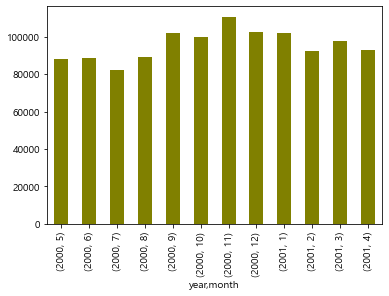

In [59]:
df_m.groupby(['year','month'])['net_amt'].mean().plot(kind='bar',color='olive')

> 2000년 11월 실구매액 평균이 높은것을 알 수 있음.

<AxesSubplot: xlabel='year,month'>

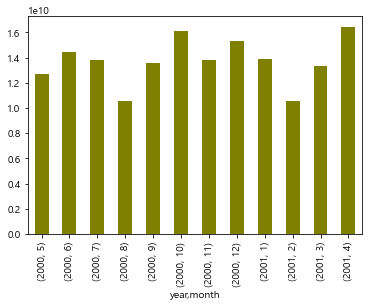

In [60]:
df_m.groupby(['year','month'])['net_amt'].sum().plot(kind='bar',color='olive')

> 2000년 10월과 2001년 4월 실구매액 합계가 높은것을 알 수 있음.

<AxesSubplot: xlabel='day'>

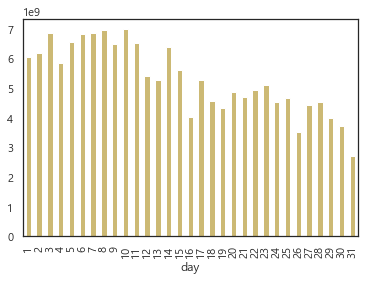

In [769]:
df_m.groupby(['day'])['net_amt'].sum().plot(kind='bar',color='y')

<AxesSubplot: xlabel='day'>

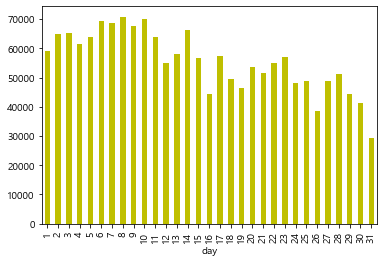

In [55]:
df_m.groupby(['day'])['net_amt'].count().plot(kind='bar',color='y')

> - 월 초가 월말보다 실구매액 합계가 높고, 구매고객이 비교적 많은 것을 알 수 있다.

<AxesSubplot: xlabel='month'>

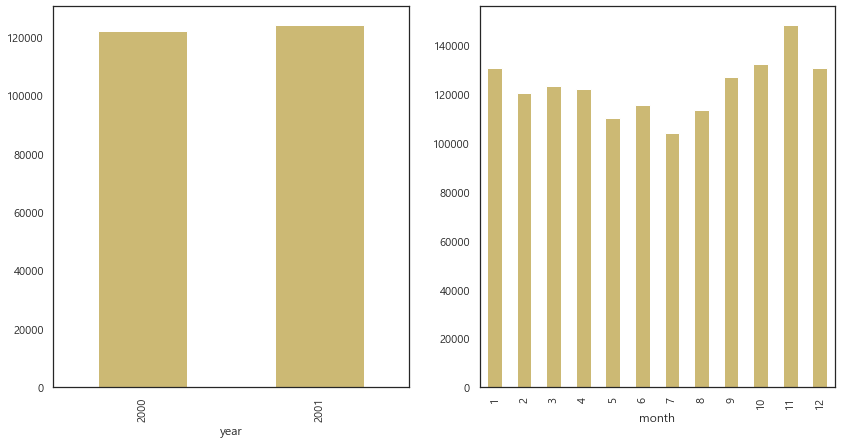

In [768]:
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m1 = df_m.query("tot_amt > 0")  # 환불제외
df_m1.groupby('year')['tot_amt'].mean().plot(kind='bar', ax=axs[0], color='y')
df_m1.groupby('month')['tot_amt'].mean().plot(kind='bar', color='y')

> - 평군 구매횟수는 2000년과 2001년 비슷함.

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format) # 항상 float 형식으로

In [73]:
# 1년동안 구매액, 할인액, 실구매액 합계

data_s = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()
data_s.describe()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\1207735180.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_s = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()


,tot_amt,dis_amt,net_amt
count,49995.00,49995.00,49995.00
mean,3407255.12,115807.42,3291447.70
std,5105558.80,235824.40,4912428.96
min,-11390811.00,-585610.00,-10805201.00
25%,713224.00,18265.00,690079.50
50%,1791300.00,49750.00,1733670.00
75%,4037737.00,121600.00,3905843.50
max,126220097.00,11429950.00,114790147.00


In [92]:
df_m1 = df_m.query("tot_amt > 0")
data_s1 = df_m1.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()
data_s1.query("tot_amt.min()")

C:\Users\User\AppData\Local\Temp\ipykernel_7616\2904332943.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_s1 = df_m1.groupby(["custid"])['tot_amt','dis_amt','net_amt'].sum()


tot_amt    288800
dis_amt      5390
net_amt    283410
Name: 16100, dtype: int64

In [106]:
df_m1.query("custid == 16100")['sales_date']  # 환불일자 제외

376197   2000-10-25
376199   2000-11-02
376200   2001-01-08
376201   2001-02-01
376202   2001-02-03
376203   2001-02-16
376204   2001-04-22
Name: sales_date, dtype: datetime64[ns]

> - 1년 구매액 평균 3,407,255 원
> - 할인액 평균 115,807 원
> - 실구매액 평균 3,291,447 원

> - 1년 구매액 합계 가장 낮은고객 id는 16100          
> 금액 : 288,800 원, 방문 횟수 (방문일 기준) 7회 

In [103]:
data1.describe()

,tot_amt,dis_amt,net_amt
count,49995.00,49995.00,49995.00
mean,3407255.12,115807.42,3291447.70
std,5105558.80,235824.40,4912428.96
min,-11390811.00,-585610.00,-10805201.00
25%,713224.00,18265.00,690079.50
50%,1791300.00,49750.00,1733670.00
75%,4037737.00,121600.00,3905843.50
max,126220097.00,11429950.00,114790147.00


> - 1년치 환불 최대고객 금액 11,390,811 원
> - 1년치 할인 최대고객 금액 11,429,950 원

In [104]:
# 환불 최대 많이 받은 고객 궁금
data1.query("tot_amt == -11390811")

,tot_amt,dis_amt,net_amt
custid,,,
13008,-11390811,-585610,-10805201


In [109]:
df_m.query("custid == 13008").head() # 30번 중 2번 환불

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
291708,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,잡화가용팀,잡화파트,화장품,수입종합화장품,138000,6900,131100,2000,5,6
291709,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,의류패션팀,"케주얼,구두,아동",영트렌디,영트랜드,29000,0,29000,2000,5,6
291710,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,잡화가용팀,명품잡화,명품시즌,스타킹,9000,450,8550,2000,5,7
291711,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,잡화가용팀,명품잡화,란제리,란제리,76000,3800,72200,2000,5,7
291712,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,의류패션팀,여성의류파트,"니트,단품,모피",모피,-12640000,-632000,-12008000,2000,5,30


In [110]:
df_m.query("custid == 13008").query("tot_amt < 0")

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
291712,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,의류패션팀,여성의류파트,"니트,단품,모피",모피,-12640000,-632000,-12008000,2000,5,30
291732,13008,2,1972-05-12 00:00:00,1,2,A,3,2,3010,5,...,잡화가용팀,잡화파트,화장품,수입종합화장품,-168000,-8400,-159600,2000,11,11


> - 환불 상품 2개, 모피와 화장품               
> 모피가 12,640,000원으로 환불횟수는 2번이지만 1년동안 가장 많은 환불액을 가진 고객이 됨.          

In [115]:
# 가장 구매액 높은 고객의 방문횟수와 구매상품 궁금.
i = df_m.query("custid == 47465")

In [118]:
print(i.shape) 
i.head()

(243, 25)


,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
1621145,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,...,의류패션팀,"케주얼,구두,아동",트레디셔널,트래디셔널,90000,9000,81000,2000,5,1
1621146,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,...,의류패션팀,여성의류파트,디자이너부띠끄,디자이너숍,954000,95400,858600,2000,5,5
1621147,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,...,의류패션팀,"케주얼,구두,아동",내의란제리,내의,4400,440,3960,2000,5,5
1621148,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,...,의류패션팀,여성의류파트,디자이너부띠끄,디자이너숍,238000,23800,214200,2000,5,7
1621149,47465,1,1941-04-01 00:00:00,1,1,N,1,17,3600,1,...,식품팀,생식품파트,미확인pc,용기보증,31752,0,31752,2000,5,7


In [125]:
print(i.query('tot_amt > 0').shape) 

(203, 25)


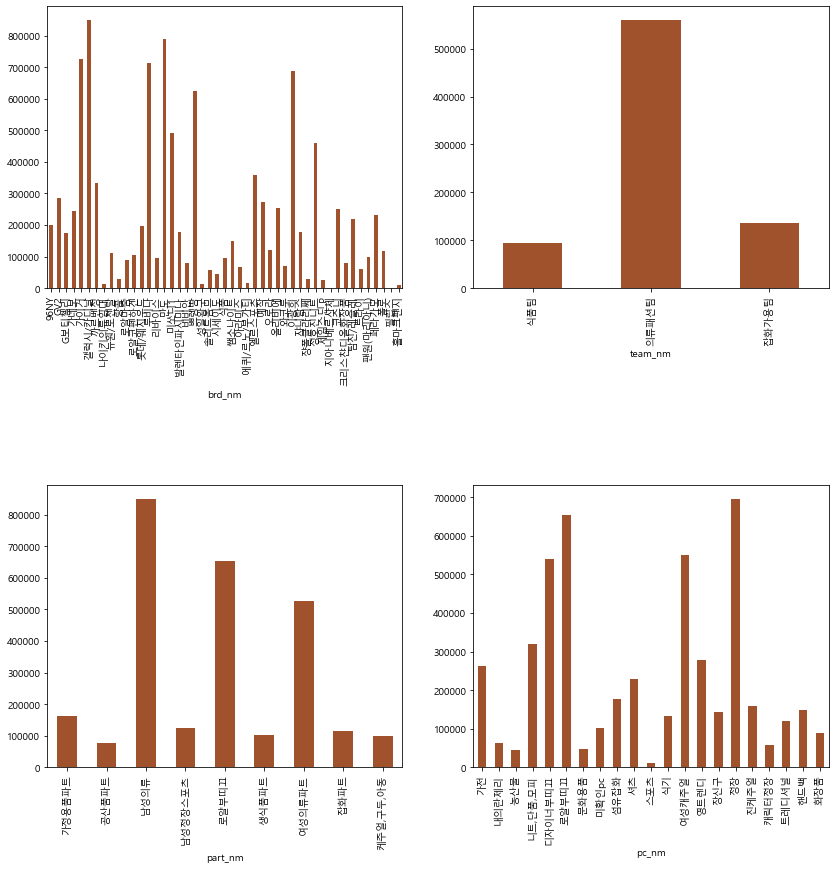

In [127]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

li = ['brd_nm', 'team_nm', 'part_nm', 'pc_nm']
for num, a in enumerate(li):
    row = int(num/2); col = num%2
    i.groupby(a)['net_amt'].mean().plot(kind='bar', ax=axs[row][col], color='sienna')

> - 1년 구매액 합계 top1 고객의 평균 구매액 분류 확인              
> 의류패션팀에 평균 구매금액이 가장 높음, 파트코드에서도 남성의류, 로얄부띠끄, 여성의류 에서 평균 구매액이 높음.         
> 상품군 코드를 보면 정장과 로얄부띠끄/디자이너부띠끄/모피,니트,단품 에서 평균 구매금액이 높은 것을 알 수 있음.         

<AxesSubplot: xlabel='team_nm'>

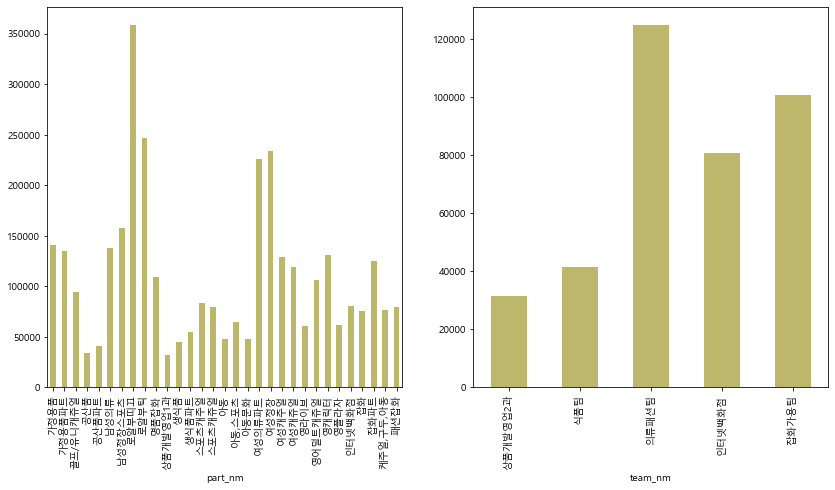

In [152]:
# 파트별 평균 구매액, 할인액, 실구매액
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0], color='darkkhaki')
df_m.groupby('team_nm')['net_amt'].mean().plot(kind='bar', color='darkkhaki')

> 전체 고객의 1년 평균 실구매액이 가장 높은 팀은 의류패션팀이고 2위는 잡화가용팀임.           
> 로얄 부띠끄에서 평균 실구매액이 높은데, 가격대가 높기 때문인 것으로 유추됨.

<AxesSubplot: xlabel='team_nm'>

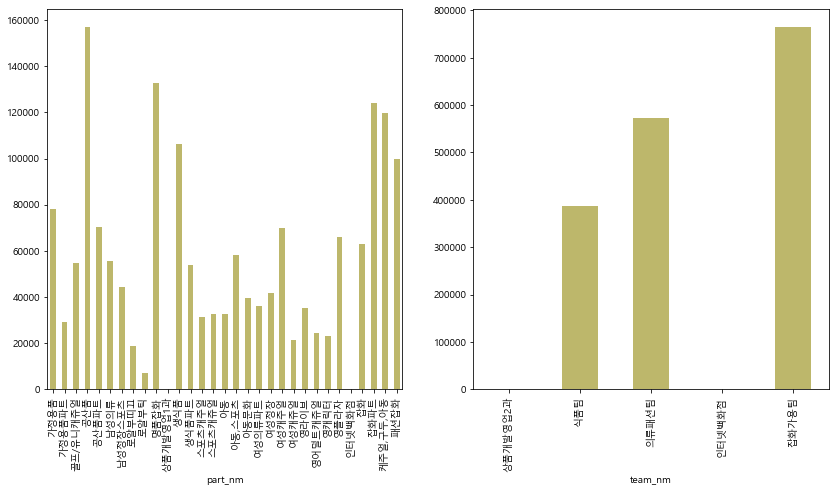

In [177]:
# 금액말고 구매 횟수로 확인해보기
# 파트별 평균 구매액, 할인액, 실구매액
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m.groupby('part_nm')['custid'].count().plot(kind='bar', ax=axs[0], color='darkkhaki')
df_m.groupby('team_nm')['custid'].count().plot(kind='bar', color='darkkhaki')

> - 팀코드 에서는 구매 횟수 가장높은 곳은 잡화가용팀, 그다음 의류패션, 식품 순으로 고객 구매횟수 높음.    
> - 파트코드를 보면 공산품의 구매가 가장 높고, 명품잡화, 잡화, 캐주얼 등 패션잡화 순으로 구매횟수 높음.

**결혼여부에 따라 구매금액 비교 및 구매파트 비교**

**미혼**

In [167]:
# 미혼 데이터 살펴보기
df_m_0 = df_m.query("mrg_flg_gb == 0")
data1 = df_m_0.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data1 = pd.DataFrame(data1)
data1.head()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\2809836600.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m_0.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt            dis_amt            net_amt          
            mean       sum     mean      sum      mean       sum
custid                                                          
4       68233.33    409400  4683.33    28100  63550.00    381300
5       43250.00    173000  4325.00    17300  38925.00    155700
6       71644.83   2077700  2079.31    60300  69565.52   2017400
7      260581.82   2866400 17854.55   196400 242727.27   2670000
8       47052.71  11433809  4322.06  1050260  42730.65  10383549

In [168]:
data1.tot_amt.sort_values(by = ['mean','sum'], ascending=False).head()

,mean,sum
custid,,
14744,1643750.00,6575000
19972,1528750.00,12230000
32837,1448000.00,4344000
30231,1303000.00,6515000
17536,1272000.00,2544000


<AxesSubplot: xlabel='month'>

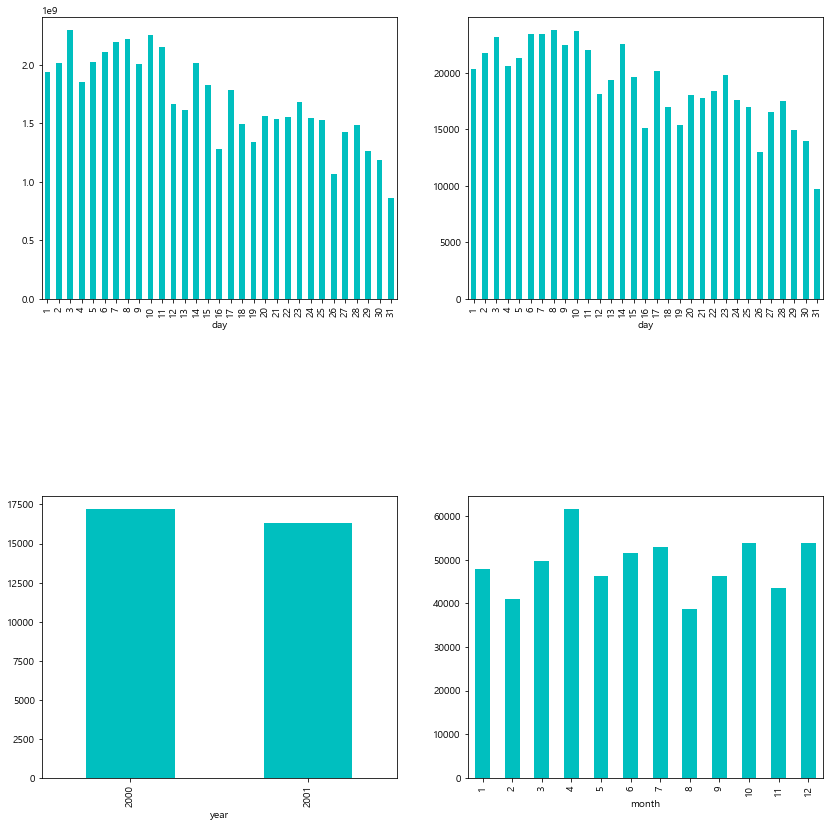

In [171]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m_0.groupby(['day'])['net_amt'].sum().plot(kind='bar', ax=axs[0][0], color='c')
df_m_0.groupby(['day'])['net_amt'].count().plot(kind='bar',ax=axs[0][1] ,color='c')
df_m_0.groupby('year')['custid'].mean().plot(kind='bar', ax=axs[1][0], color='c')
df_m_0.groupby('month')['custid'].count().plot(kind='bar',ax=axs[1][1], color='c')

> 전체 고객의 데이터와 유사한 형태를 보임.

In [172]:
data1.describe()

tot_amt                dis_amt               net_amt             
            mean          sum      mean        sum       mean          sum
count   22516.00     22516.00  22516.00   22516.00   22516.00     22516.00
mean    96221.48   2439291.92   3751.68   93285.93   92469.80   2346005.99
std     73902.26   3692226.55   3988.02  177248.52   70909.43   3541487.86
min   -818500.00 -11390811.00 -40925.00 -585610.00 -777575.00 -10805201.00
25%     53476.54    550000.00   1508.46   16300.00   51564.39    528193.00
50%     78148.65   1339985.00   2735.77   42640.00   75050.00   1292115.00
75%    116397.97   2920039.00   4700.00  100690.00  111625.00   2807626.00
max   1643750.00 114239035.00 152875.00 4827670.00 1561562.50 109521205.00

> - 3일과, 월별로는 4월에 구매횟수가 높은 것을 알 수 있음.          
> - 미혼 고객의 평균 구매액은 96,221 원, 1년 구매액 합계 평균은 2,439,291원 임.

<AxesSubplot: xlabel='team_nm'>

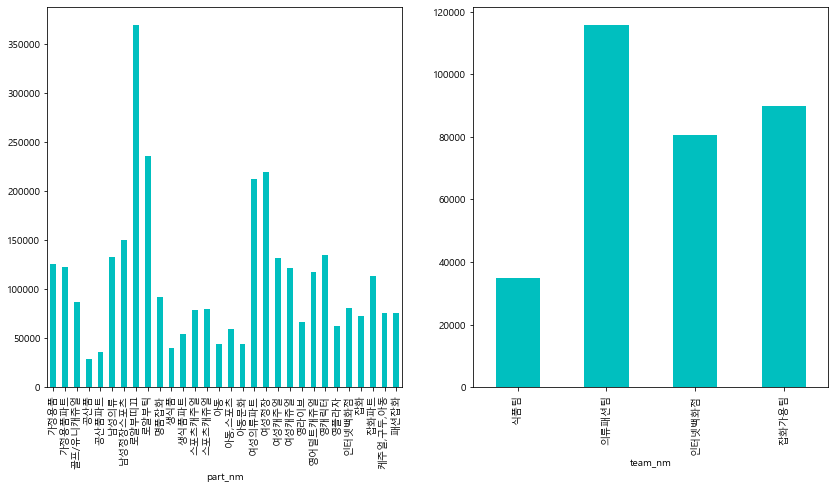

In [176]:
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m_0.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0], color='c')
df_m_0.groupby('team_nm')['net_amt'].mean().plot(kind='bar', color='c')

<AxesSubplot: xlabel='team_nm'>

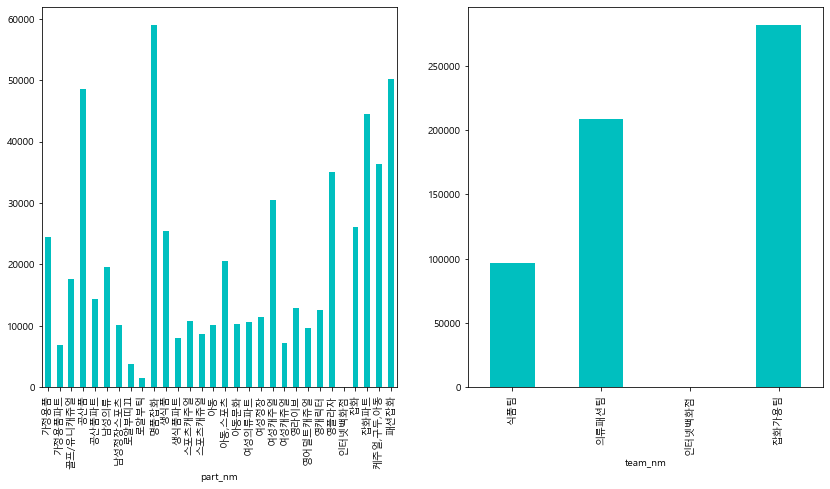

In [181]:
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m_0.groupby('part_nm')['net_amt'].count().plot(kind='bar', ax=axs[0], color='c')
df_m_0.groupby('team_nm')['net_amt'].count().plot(kind='bar', color='c')

> - 미혼고객의 평균실구매액이 가장 높은 파트는 로얄부띠끄 인 것을 알 수 있음.                
> - 팀파트에서도 의류패션팀의 평균 실구매액이 가장 높고, 잡화가용팀, 인터넷백화점, 식품팀 순인 것을 확인할 수 있음.        
> - 구매횟수는 명품잡화, 공산품순으로 높음.          
>  전체에서는 공산품이 가장 놓았는데, **미혼인 경우** 명품잡화의 구매횟수가 더 높은것 을 알 수 있음.    
> - 잡화가용팀, 의류패션팀 순으로 구매횟수가 많은 것을 확인할 수 있음.


<AxesSubplot: title={'center': '미혼고객남성 팀별 구매횟수'}, xlabel='team_nm'>

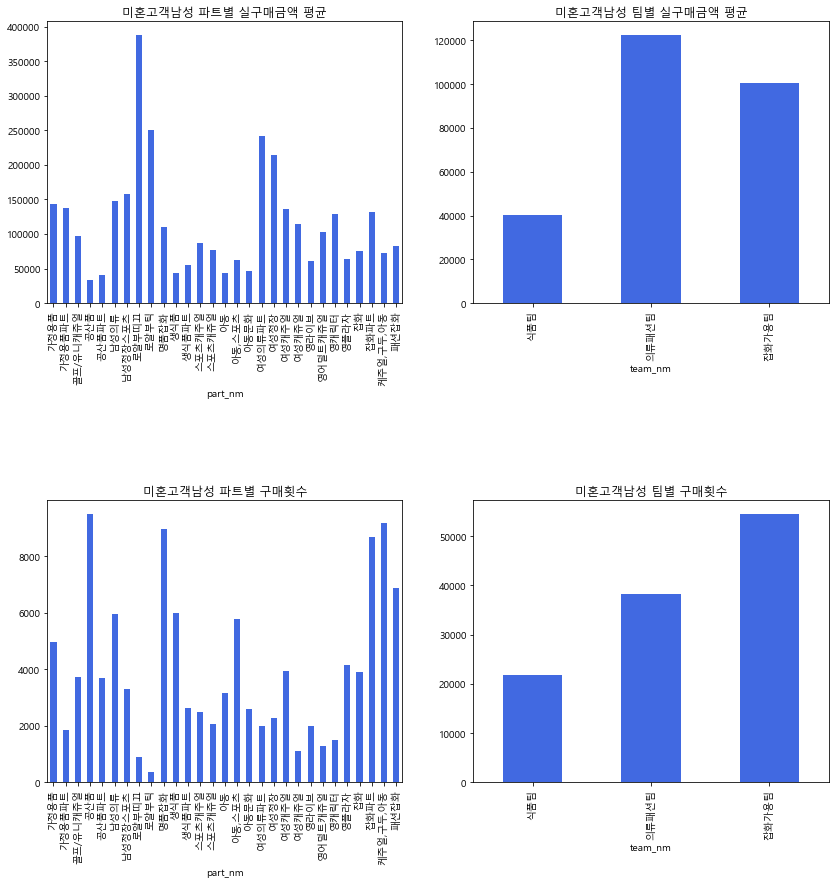

In [180]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

# 미혼고객 남성
df_m_01 = df_m_0.query("sex == 1")
df_m_01.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][0], color='royalblue',title="미혼고객남성 파트별 실구매금액 평균")
df_m_01.groupby('team_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][1], color='royalblue',title="미혼고객남성 팀별 실구매금액 평균")
df_m_01.groupby('part_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][0], color='royalblue',title="미혼고객남성 파트별 구매횟수")
df_m_01.groupby('team_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][1], color='royalblue',title="미혼고객남성 팀별 구매횟수")

In [183]:
data1 = df_m_01.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data1 = pd.DataFrame(data1)
data1.describe()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\18928473.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m_01.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt               dis_amt               net_amt            
            mean         sum      mean        sum       mean         sum
count    3991.00     3991.00   3991.00    3991.00    3991.00     3991.00
mean   111164.01  2892906.12   4831.60  124750.91  106332.41  2768155.21
std     91693.34  4125502.69   5878.88  229540.43   87314.48  3935529.30
min    -13963.62  -404945.00    -11.90    -750.00  -14436.03  -418645.00
25%     58499.30   626488.50   1733.33   19385.00   55752.08   602560.00
50%     88833.33  1535038.00   3340.00   51250.00   85032.00  1477250.00
75%    133274.13  3475639.50   6127.76  132290.00  127369.72  3333577.00
max   1643750.00 61247995.00 152875.00 3878330.00 1561562.50 57446745.00

In [191]:
df_m_0.query("tot_amt > 0").shape, df_m_01.query("tot_amt > 0").shape

((548372, 25), (106988, 25))

> (미혼고객 남성의 경우)
> - 실구매액 평균은 로얄부띠끄가 가장높고 로얄부틱,여성의류파트, 여성정장 순으로 금액이 높음.          
>  미혼남성고객이 여성 선물을 구매하는 것으로 유추됨.


> - 팀별 구매횟수는 잡화 > 의류 > 식품 순으로 많았으며,            
> 공산품이 가장 구매횟수가 높고 그다음으로 명품잡화, 잡화파트 순으로 확인됨.
> - 로얄부띡의 구매횟수는 가장 낮은데, 실구매금액 평균이 높은것으로 보아 해당 파트의 가격대가 높음을 유추할 수 있음.     

> - 구매금액 평균과 합계는 전체 미혼 구매금액 데이터보다 높음.             
  미혼 전체 : 96221.48 / 2439291.92           
  미혼 남성 : 111164.01 /2892906.12

<AxesSubplot: title={'center': '미혼고객여성 팀별 구매횟수'}, xlabel='team_nm'>

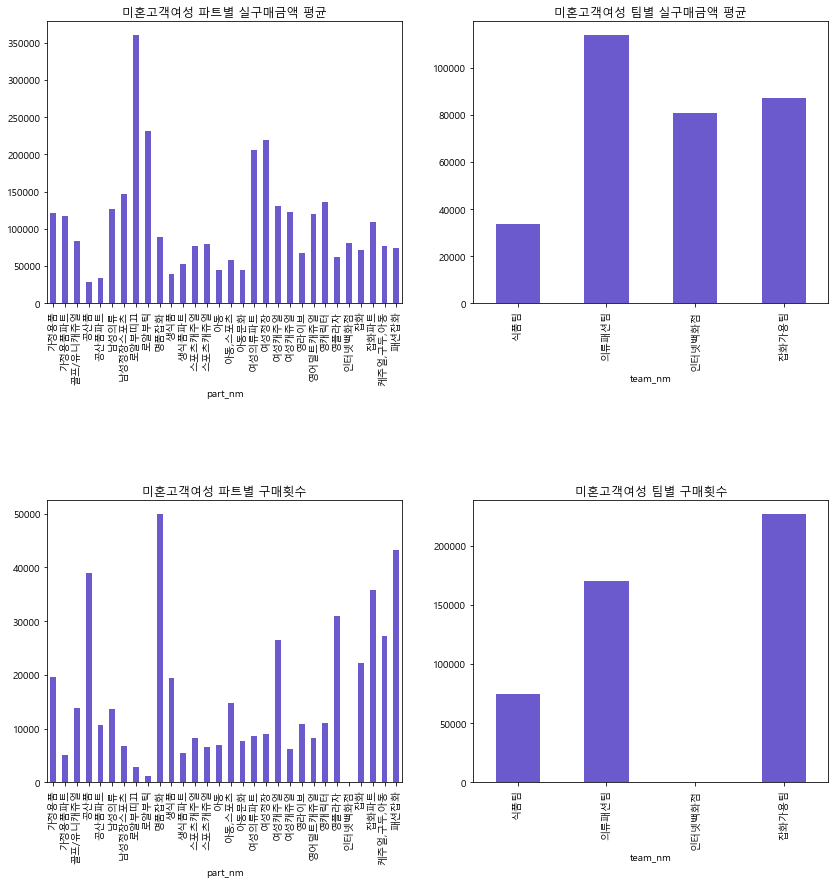

In [196]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

# 미혼고객 남성
df_m_02 = df_m_0.query("sex == 2")
df_m_02.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][0], color='slateblue',title="미혼고객여성 파트별 실구매금액 평균")
df_m_02.groupby('team_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][1], color='slateblue',title="미혼고객여성 팀별 실구매금액 평균")
df_m_02.groupby('part_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][0], color='slateblue',title="미혼고객여성 파트별 구매횟수")
df_m_02.groupby('team_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][1], color='slateblue',title="미혼고객여성 팀별 구매횟수")

In [204]:
df_m_02['team_nm'].value_counts()

잡화가용팀     227023
의류패션팀     170278
식품팀        74563
인터넷백화점         1
Name: team_nm, dtype: int64

In [206]:
df_m_02_ = df_m_02[df_m_02['team_nm'] == "인터넷백화점"]
df_m_02_

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
1655069,48231,2,1939-10-01 00:00:00,2,2,N,1,17,7060,3,...,인터넷백화점,인터넷백화점,사이버쇼핑,홈쇼핑,85000,4250,80750,2001,2,22


In [208]:
df_m_02_[['sales_date', 'cus_stype','goodcd', 'brd_nm', 'team_nm', 'part_nm', 'pc_nm','corner_nm']]
# 올젠이라는 의류브랜드 상품을 홈쇼핑에서 구매함.
# 초우량 3등급의 고객임.

,sales_date,cus_stype,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm
1655069,2001-02-22,3,2300500019900,올젠,인터넷백화점,인터넷백화점,사이버쇼핑,홈쇼핑


> - 미혼여성고객 **인터넷백회점 구매횟수가 1번** 뿐이라, 평균금액이 높았던 것을 알 수 있음.

In [198]:
data2 = df_m_02.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data2 = pd.DataFrame(data2)
data2.describe()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\1811136580.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data2 = df_m_02.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt                dis_amt               net_amt             
            mean          sum      mean        sum       mean          sum
count   18513.00     18513.00  18513.00   18513.00   18513.00     18513.00
mean    92934.65   2339090.27   3515.91   86363.22   89418.74   2252727.05
std     68931.76   3578531.23   3397.04  162373.80   66357.27   3438474.45
min   -818500.00 -11390811.00 -40925.00 -585610.00 -777575.00 -10805201.00
25%     52632.39    535000.00   1474.52   15750.00   50711.41    516590.00
50%     76144.44   1296957.00   2628.33   41150.00   73163.33   1252092.00
75%    112500.00   2808400.00   4434.62   94550.00  108146.15   2707796.00
max   1448000.00 114239035.00  63600.00 4827670.00 1412266.67 109521205.00

> (미혼여성고객의 경우)
> - 미혼 남성 고객에서는 안보이던 인터넷백화점 파트가 보임.
> - 의류패션, 잡화, 인터넷 백화점 순으로 실구매금액 평균이 높음.
> - 실구매 금액 평균이 가장 높은 파트는 동일하게 로얄부띠끄.

> - 구매횟수는 명품잡화가 가장 많고, 이후로 패션잡화, 공산품 순서.
> - 인터넷 백화점 구매횟수는 다른 팀코드에 비해서 매우 작지만 구매금액이 높은걸로 보아 가격대가 높은 상품을 인터넷 백화점에서 구매함. 
> - 하지만 구매횟수가 1번이라 평균으로 비교될 수 없음.

> - 구매금액 평균과 합계는 전체 미혼 구매금액 데이터보다 낮음.             
  미혼 전체 : 96221.48 / 2439291.92           
  미혼 여성 : 92934.65 / 2339090.27          
  -> 미혼남성보다 구매금액이 조금 낮음을 알 수 잇음.

In [770]:
print("미혼전체 : ", df_m_0.query("tot_amt > 0").shape,"/ 미혼남성 : ",  
df_m_01.query("tot_amt > 0").shape, "/ 미혼여성 : ",  df_m_02.query("tot_amt > 0").shape)

미혼전체 :  (548372, 25) / 미혼남성 :  (106988, 25) / 미혼여성 :  (441012, 25)


> - 미혼 남성 구매데이터(구매횟수) 보다 미혼 여성이 구매정보가 많음. 1 : 4

**기혼**

In [210]:
# 기혼 데이터 살펴보기
df_m_1 = df_m.query("mrg_flg_gb == 1")
data1 = df_m_1.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data1 = pd.DataFrame(data1)
data1.head()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\3716854843.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m_1.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt          dis_amt         net_amt         
           mean      sum    mean    sum     mean      sum
custid                                                   
1      49356.90  3800481  546.75  42100 48810.14  3758381
2      76154.61  2132329 2541.07  71150 73613.54  2061179
3      95465.28  6491639  964.56  65590 94500.72  6426049
93     49961.33   749420 1937.33  29060 48024.00   720360
161    79107.14  2215000 3217.86  90100 75889.29  2124900

In [212]:
data1.describe()

tot_amt                dis_amt                net_amt             
            mean          sum      mean         sum       mean          sum
count   27479.00     27479.00  27479.00    27479.00   27479.00     27479.00
mean   107096.62   4200393.85   3516.39   134261.28  103580.23   4066132.56
std     97662.99   5904167.55   4189.82   273285.31   94876.16   5683021.43
min    -76504.00  -1453576.00  -9302.73  -410060.00  -78975.58  -1500536.00
25%     55906.26    929108.50   1200.00    20515.00   54418.56    901796.50
50%     84500.00   2313000.00   2387.50    57150.00   81704.87   2241622.00
75%    128688.14   5129748.50   4350.00   140845.00  124351.91   4975539.00
max   6845000.00 126220097.00 100321.43 11429950.00 6844625.00 114790147.00

> - 미혼고객보다 평균 구매액도 높고, 구매액 합계도 약 2배임.

<AxesSubplot: xlabel='month'>

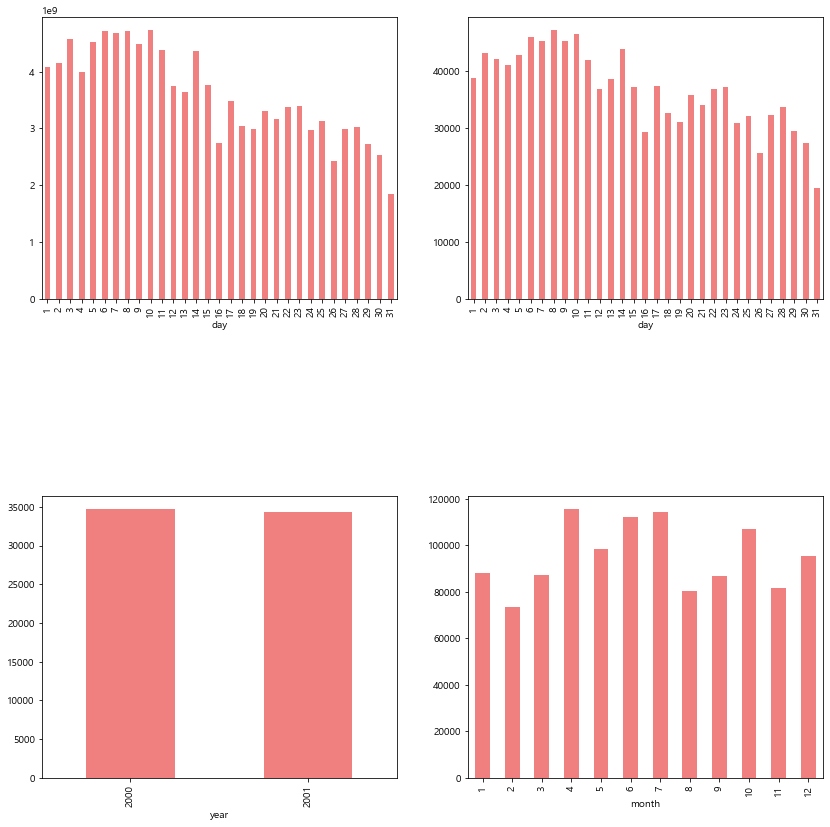

In [211]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

df_m_1.groupby(['day'])['net_amt'].sum().plot(kind='bar', ax=axs[0][0], color='lightcoral')
df_m_1.groupby(['day'])['net_amt'].count().plot(kind='bar',ax=axs[0][1] ,color='lightcoral')
df_m_1.groupby('year')['custid'].mean().plot(kind='bar', ax=axs[1][0], color='lightcoral')
df_m_1.groupby('month')['custid'].count().plot(kind='bar',ax=axs[1][1], color='lightcoral')

> 구매일자는 비슷한 모양임.

<AxesSubplot: title={'center': '기혼고객남성 팀별 구매횟수'}, xlabel='team_nm'>

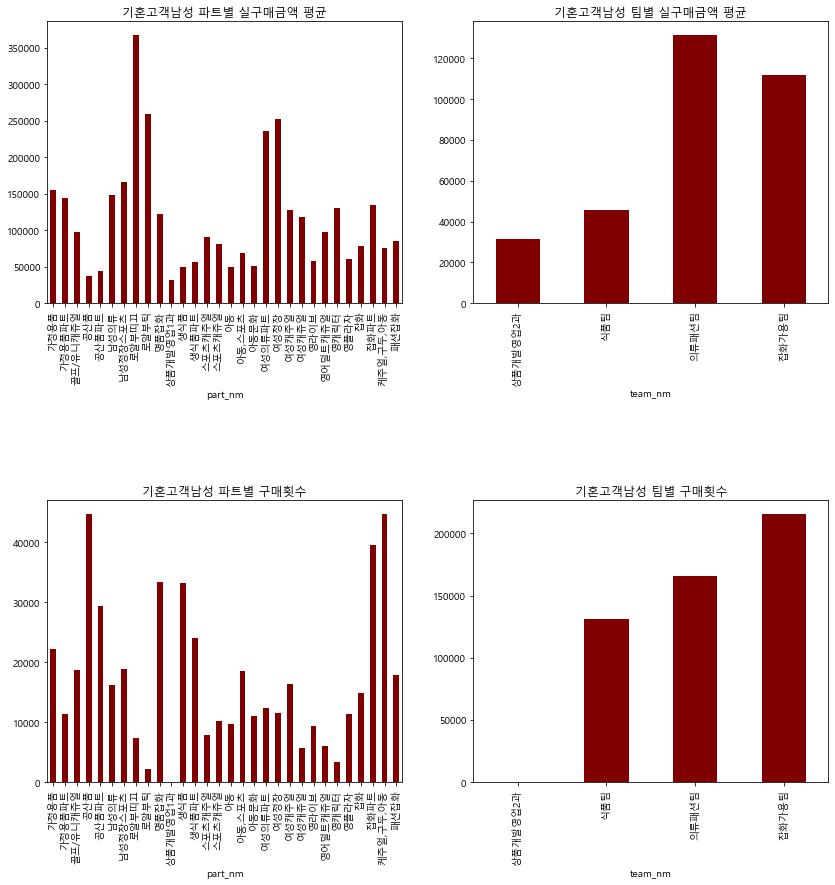

In [229]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

# 기혼고객 남성
df_m_11 = df_m_1.query("sex == 1")
df_m_11.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][0], color='maroon',title="기혼고객남성 파트별 실구매금액 평균")
df_m_11.groupby('team_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][1], color='maroon',title="기혼고객남성 팀별 실구매금액 평균")
df_m_11.groupby('part_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][0], color='maroon',title="기혼고객남성 파트별 구매횟수")
df_m_11.groupby('team_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][1], color='maroon',title="기혼고객남성 팀별 구매횟수")

In [227]:
data1 = df_m_11.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data1 = pd.DataFrame(data1)
data1.describe()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\3540870664.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m_11.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt               dis_amt                net_amt             
            mean          sum     mean         sum       mean          sum
count   11171.00     11171.00 11171.00    11171.00   11171.00     11171.00
mean   110434.67   4810215.23  3815.07   167637.67  106619.61   4642577.57
std    109157.52   6693672.02  4399.08   352327.11  106771.39   6412391.90
min    -27834.16   -695854.00 -4202.94   -71450.00  -28934.16   -723354.00
25%     57918.63   1104402.00  1284.16    24900.00   55966.27   1067384.00
50%     87574.43   2657100.00  2555.36    68850.00   84450.00   2570519.00
75%    132872.45   5940291.00  4743.03   171190.00  128209.26   5742656.50
max   6845000.00 126220097.00 94644.44 11429950.00 6844625.00 114790147.00

> - 기혼남성도 미혼남성, 여성과 마찬가지로 로얄부띠끄의 평균 구매액이 가장 높음.
> - 기혼남성은 미혼고객과 다르게 **상품개발영업2과** 팀에 구매액이 있음.
> - 미혼 고객과는 다르게 공산품이 가장 구매횟수가 많고,    
  그 다음이 잡화, 명품잡화 이며 **생식품에 대한 구매**가 명품잡화와 비슷함.

> - 구매금액 평균과 합계는 전체 기혼 구매금액 데이터보다 높음.             
  기혼 전체 : 107096.62 / 4200393.85           
  기혼 남성 : 110434.67 / 4810215.23
	

In [308]:
df_m_11_ = df_m_11[df_m_11['team_nm'] == "상품개발영업2과"]
df_m_11_

,custid,sex,birth,birth_flg,mrg_flg,h_type1,h_type2,hobby,job_stype,cus_stype,...,team_nm,part_nm,pc_nm,corner_nm,tot_amt,dis_amt,net_amt,year,month,day
1066863,34898,1,$null$,-1,1,A,1,17,4160,1,...,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,94000,4700,89300,2000,8,8
1327158,40812,1,1951-02-11 00:00:00,2,1,V,1,17,7060,9,...,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,39000,1950,37050,2000,8,8
1327159,40812,1,1951-02-11 00:00:00,2,1,V,1,17,7060,9,...,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,-39000,-1950,-37050,2000,8,8
1577390,46393,1,$null$,-1,1,A,1,17,6030,6,...,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,39000,1950,37050,2000,8,8


In [311]:
df_m_11_[['custid','sales_date', 'cus_stype','goodcd', 'brd_nm', 'team_nm', 'part_nm', 'pc_nm','corner_nm','tot_amt']]

,custid,sales_date,cus_stype,goodcd,brd_nm,team_nm,part_nm,pc_nm,corner_nm,tot_amt
1066863,34898,2000-08-08,1,2800420013000,아르모니아,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,94000
1327158,40812,2000-08-08,9,2800420013000,아르모니아,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,39000
1327159,40812,2000-08-08,9,2800420013000,아르모니아,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,-39000
1577390,46393,2000-08-08,6,2800420013000,아르모니아,상품개발영업2과,상품개발영업1과,아르모니아,ERREVNO,39000


> - 같은 판매일자에 아르모니아 브랜드의 상품을 3명의 고객이 구매했고, 1명은 환불한 것을 알 수 있음.

<AxesSubplot: title={'center': '기혼고객여성 팀별 구매횟수'}, xlabel='team_nm'>

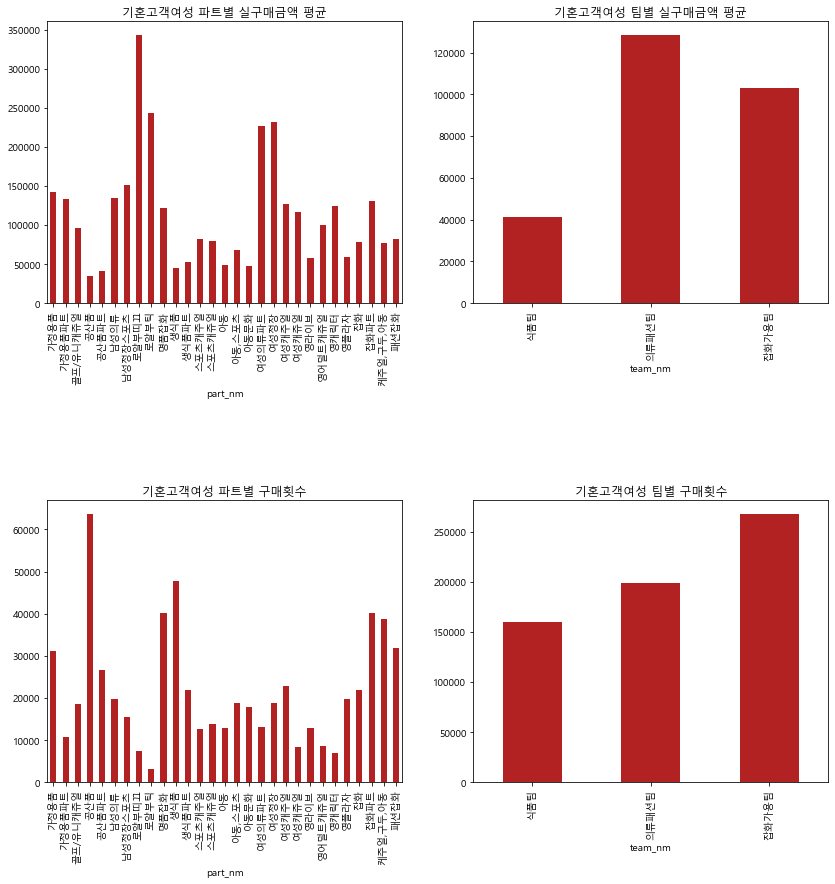

In [232]:
fig, axs = plt.subplots(figsize=(14,14), nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.7,wspace=0.2)

# 기혼고객 여성
df_m_12 = df_m_1.query("sex == 2")
df_m_12.groupby('part_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][0], color='firebrick',title="기혼고객여성 파트별 실구매금액 평균")
df_m_12.groupby('team_nm')['net_amt'].mean().plot(kind='bar', ax=axs[0][1], color='firebrick',title="기혼고객여성 팀별 실구매금액 평균")
df_m_12.groupby('part_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][0], color='firebrick',title="기혼고객여성 파트별 구매횟수")
df_m_12.groupby('team_nm')['net_amt'].count().plot(kind='bar', ax=axs[1][1], color='firebrick',title="기혼고객여성 팀별 구매횟수")

In [233]:
data1 = df_m_21.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])
data1 = pd.DataFrame(data1)
data1.describe()

C:\Users\User\AppData\Local\Temp\ipykernel_7616\2170284284.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = df_m_21.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum'])


tot_amt               dis_amt               net_amt            
            mean         sum      mean        sum       mean         sum
count   16296.00    16296.00  16296.00   16296.00   16296.00    16296.00
mean   104778.11  3777722.81   3310.33  111265.38  101467.78  3666457.44
std     88813.98  5203631.45   4026.99  197922.76   85670.04  5035724.00
min    -76504.00 -1453576.00  -9302.73 -410060.00  -78975.58 -1500536.00
25%     54666.47   841925.00   1149.01   18050.00   53237.67   816007.50
50%     82519.94  2094272.00   2271.58   50895.00   80028.54  2035037.50
75%    125808.36  4619531.75   4119.82  123062.50  122001.36  4495651.00
max   1887526.33 91288417.00 100321.43 4015010.00 1880588.83 88185167.00

In [234]:
print("기혼전체 : ", df_m_1.query("tot_amt > 0").shape,"/ 기혼남성 : ",  
df_m_11.query("tot_amt > 0").shape, "/ 기혼여성 : ",  df_m_12.query("tot_amt > 0").shape)

기혼전체 :  (1062117, 25) / 기혼남성 :  (477984, 25) / 기혼여성 :  (583704, 25)


> - 기혼여성도 로얄부띠끄가 구매액 평균이 가장 높고, 로얄부틱, 여성의류, 여성정장이 다음으로 높음.
> - 패션팀 >  잡화가용팀 >  식품팀 순서로 구매액 평균이 낮아짐.
> - 공산품과 생식품의 구매횟수가 높고 그 다음으로 명품잡화, 잡화 쪽이 높음.

> - 구매금액 평균과 합계는 전체 기혼 구매금액 데이터보다 낮음.             
  기혼 전체 : 107096.62 / 4200393.85           
  기혼 여성 : 104778.11 / 3777722.81

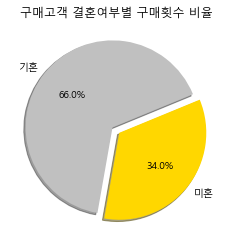

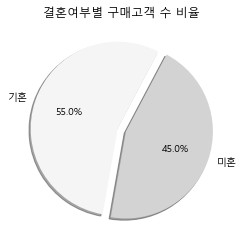

In [248]:
sum1 = df_m['mrg_flg_gb'].value_counts().sum()
data = df_m['mrg_flg_gb'].value_counts()/sum1*100
ratio = list(data.values)
labels = ['기혼', '미혼']
explode = [0.05, 0.05]
colors = ['silver', 'gold']

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title("구매고객 결혼여부별 구매횟수 비율")
plt.show()

sum1 = customers['mrg_flg_gb'].value_counts().sum()
data = customers['mrg_flg_gb'].value_counts()/sum1*100
ratio = list(data.values)
labels = ['기혼', '미혼']
explode = [0.05, 0.05]
colors = ['whitesmoke', 'lightgray']

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title("결혼여부별 구매고객 수 비율")
plt.show()

In [305]:
data = df_m.groupby(["mrg_flg_gb","sex"])["custid"].count()
d1 = pd.DataFrame(data)
data = d1.reset_index()

gb0 = data.query("mrg_flg_gb == 0")
gb1 = data.query("mrg_flg_gb == 1")

gb0["per"] = ((gb0.custid/gb0.custid.sum())) * 100
gb1["per"] = ((gb1.custid/gb1.custid.sum())) * 100


C:\Users\User\AppData\Local\Temp\ipykernel_7616\1739951187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb0["per"] = ((gb0.custid/gb0.custid.sum())) * 100
C:\Users\User\AppData\Local\Temp\ipykernel_7616\1739951187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb1["per"] = ((gb1.custid/gb1.custid.sum())) * 100


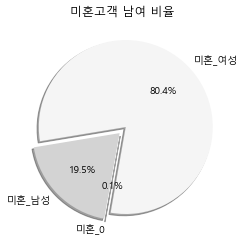

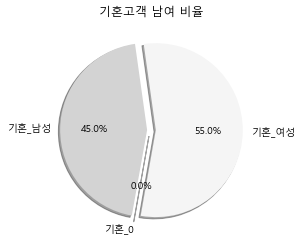

In [307]:
ratio = list(gb0.per)
labels = ['미혼_0', '미혼_남성','미혼_여성']
explode = [0.05, 0.05, 0.05]

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title("미혼고객 남여 비율")
plt.show()

ratio = list(gb1.per)
labels = ['기혼_0', '기혼_남성','기혼_여성']
explode = [0.05, 0.05, 0.05]

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title("기혼고객 남여 비율")
plt.show()

#### 데이터 전처리
- 목적 : 결혼 여부 예측
- 타겟 : 결혼 여부 코드 (mrg_flg_gb, 0:미혼+기타 1:기혼 )

In [12]:
customers.columns

Index(['custid', 'sex', 'birth', 'birth_flg', 'mrg_flg', 'h_type1', 'h_type2',
       'hobby', 'job_stype', 'cus_stype', 'm_time1', 'mrg_flg_gb',
       'birth_date'],
      dtype='object')

In [13]:
# 고객 데이터
# 널값 birth - age 생서으로 삭제, 기타 많은 job_stype 제외
df = customers.drop(["birth", "job_stype","mrg_flg"], axis=1)

In [14]:
from sklearn.preprocessing import LabelEncoder
# 라벨인코딩
li = ['birth_flg','h_type1', 'h_type2','hobby','cus_stype','m_time1']   
encoder = LabelEncoder()
label_cls = {}
for i in li:
    labels = encoder.fit_transform(list(df[f'{i}']))
    label_cls[f'{i}_cls']= list(encoder.classes_)
    df[f"{i}_label"] = list(labels)

df.drop(['h_type1', 'h_type2','hobby'], axis=1, inplace=True)

In [15]:
def cus_stype_m(x):
    if x in (1,2,3,4):
        return 1
    elif x in (5,6,7,8):
        return 2
    elif x in (9,10):
        return 3
    else : return 4

df['cus_stype_m'] = df['cus_stype'].map(cus_stype_m)
df['cus_stype_m'].value_counts()

3    18795
2    13584
4     9906
1     7710
Name: cus_stype_m, dtype: int64

In [16]:
def m_time1_m(x):
    if x <= 12 :
        return 1
    elif x <= 24:
        return 2
    elif x <= 36:
        return 3
    else : return 4

df['m_time1_m'] = df['m_time1'].map(m_time1_m)
df['m_time1_m'].value_counts()

3    32606
4    10354
2     4463
1     2572
Name: m_time1_m, dtype: int64

In [17]:
def m_time1_m2(x):
    if x <= 6 :
        return 1
#     elif x <= 12:
#         return 2
#     elif x <= 18:
#         return 3
    elif x <= 24:
        return 2
    elif x <= 30:
        return 3
    elif x <= 36:
        return 4
    elif x <= 42:
        return 5
    else : return 6

df['m_time1_m2'] = df['m_time1'].map(m_time1_m2)
df['m_time1_m2'].value_counts()

4    17852
3    14754
5    10354
2     4463
1     2572
Name: m_time1_m2, dtype: int64

In [346]:
df.head()

,custid,sex,birth_flg,cus_stype,m_time1,mrg_flg_gb,h_type1_label,h_type2_label,hobby_label,cus_stype_label,m_time1_label,cus_stype_m,m_time1_m,m_time1_m2,birth_flg_label
0,1,0,-1,7,37,1,1,1,16,6,19,2,4,5,0
1,2,0,-1,7,31,1,4,1,16,6,13,2,3,4,0
2,3,0,-1,6,22,1,1,2,16,5,4,2,2,2,0
3,4,2,1,9,35,0,4,4,10,8,17,3,3,4,1
4,5,2,1,9,-1,0,7,3,16,8,0,3,1,1,1


In [18]:
# 구매데이터
df_m.drop(['sex', 'birth', 'birth_flg', 'mrg_flg', 'h_type1', 'h_type2',
       'hobby', 'job_stype', 'cus_stype', 'm_time1', 'mrg_flg_gb'], axis=1, inplace=True)
df_m.columns

Index(['custid', 'sales_date', 'goodcd', 'brd_nm', 'team_nm', 'part_nm',
       'pc_nm', 'corner_nm', 'tot_amt', 'dis_amt', 'net_amt'],
      dtype='object')

In [19]:
data_s = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum','count'])
data_s

C:\Users\User\AppData\Local\Temp\ipykernel_8960\2819514195.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_s = df_m.groupby(["custid"])['tot_amt','dis_amt','net_amt'].agg(['mean','sum','count'])


tot_amt                       dis_amt                 \
                 mean       sum count          mean      sum count   
custid                                                               
1        49356.896104   3800481    77    546.753247    42100    77   
2        76154.607143   2132329    28   2541.071429    71150    28   
3        95465.279412   6491639    68    964.558824    65590    68   
4        68233.333333    409400     6   4683.333333    28100     6   
5        43250.000000    173000     4   4325.000000    17300     4   
...               ...       ...   ...           ...      ...   ...   
49996   580062.485380  99190685   171  15276.725146  2612320   171   
49997   183154.782609   8425120    46   5927.173913   272650    46   
49998    49344.486486   1825746    37   1043.243243    38600    37   
49999   128862.625000   3092703    24   8558.333333   205400    24   
50000   112038.965517   3249130    29  10096.896552   292810    29   

              net_amt                  
                 mean       sum count  
custid                                 
1        48810.142857   3758381    77  
2        73613.535714   2061179    28  
3        94500.720588   6426049    68  
4        63550.000000    381300     6  
5        38925.000000    155700     4  
...               ...       ...   ...  
49996   564785.760234  96578365   171  
49997   177227.608696   8152470    46  
49998    48301.243243   1787146    37  
49999   120304.291667   2887303    24  
50000   101942.068966   2956320    29  

[49995 rows x 9 columns]

In [354]:
data_s.reset_index()

custid   tot_amt                  dis_amt                  net_amt  \
                  mean       sum count     mean      sum count      mean   
0          1  49356.90   3800481    77   546.75    42100    77  48810.14   
1          2  76154.61   2132329    28  2541.07    71150    28  73613.54   
2          3  95465.28   6491639    68   964.56    65590    68  94500.72   
3          4  68233.33    409400     6  4683.33    28100     6  63550.00   
4          5  43250.00    173000     4  4325.00    17300     4  38925.00   
...      ...       ...       ...   ...      ...      ...   ...       ...   
49990  49996 580062.49  99190685   171 15276.73  2612320   171 564785.76   
49991  49997 183154.78   8425120    46  5927.17   272650    46 177227.61   
49992  49998  49344.49   1825746    37  1043.24    38600    37  48301.24   
49993  49999 128862.62   3092703    24  8558.33   205400    24 120304.29   
49994  50000 112038.97   3249130    29 10096.90   292810    29 101942.07   

                       
            sum count  
0       3758381    77  
1       2061179    28  
2       6426049    68  
3        381300     6  
4        155700     4  
...         ...   ...  
49990  96578365   171  
49991   8152470    46  
49992   1787146    37  
49993   2887303    24  
49994   2956320    29  

[49995 rows x 10 columns]

In [20]:
datas1 = data_s.reset_index()
datas1.columns = ['custid','tot_amt_m','tot_amt_s','tot_amt_c','dis_amt_m','dis_amt_s','dis_amt_c','net_amt_m','net_amt_s','net_amt_c']
datas1 = datas1.drop(['dis_amt_c','net_amt_c'], axis = 1)

In [359]:
datas1.head(2)

,custid,tot_amt_m,tot_amt_s,tot_amt_c,dis_amt_m,dis_amt_s,net_amt_m,net_amt_s
0,1,49356.90,3800481,77,546.75,42100,48810.14,3758381
1,2,76154.61,2132329,28,2541.07,71150,73613.54,2061179


In [21]:
df_s = datas1.drop(['custid','tot_amt_c'], axis=1)
df_s.columns

Index(['tot_amt_m', 'tot_amt_s', 'dis_amt_m', 'dis_amt_s', 'net_amt_m',
       'net_amt_s'],
      dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_std = scaler.fit_transform(df_s)

std_result = pd.DataFrame(df_std, columns = ['tot_amt_m_std', 'tot_amt_s_std', 
    'dis_amt_m_std','dis_amt_s_std', 'net_amt_m_std','net_amt_s_std'])
std_result['custid'] = datas1['custid'].copy()

In [23]:
from sklearn.preprocessing import MinMaxScaler

minmax_data = datas1[['dis_amt_s']]
scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(minmax_data)

std_result['dis_amt_s_minmax'] = df_minmax

In [24]:
df.shape, std_result.shape

((49995, 16), (49995, 8))

In [25]:
df_x = pd.merge(df,std_result, how='left', on=['custid'])

In [26]:
# 구매일자 cnt
data1 = df_m.groupby(["custid",'sales_date'])['tot_amt'].count()
data1 = pd.DataFrame(data1)
date_c = pd.DataFrame(data1.reset_index().drop('tot_amt',axis=1).groupby(["custid"])['custid'].count())
date_c.columns = ['date_c']
date_c.reset_index()

,custid,date_c
0,1,41
1,2,11
2,3,27
3,4,4
4,5,3
...,...,...
49990,49996,52
49991,49997,20
49992,49998,24
49993,49999,17


In [27]:
# 구매상품 중복제거 개수 cnt
data1 = df_m.groupby(["custid",'goodcd'])['tot_amt'].count()
data1 = pd.DataFrame(data1)
item_c = pd.DataFrame(data1.reset_index().drop('tot_amt',axis=1).groupby(["custid"])['custid'].count())
item_c.columns = ['item_c']
item_c.reset_index()

,custid,item_c
0,1,29
1,2,17
2,3,37
3,4,6
4,5,4
...,...,...
49990,49996,39
49991,49997,22
49992,49998,22
49993,49999,12


In [28]:
date_c['item_c'] = item_c

In [29]:
# 월말(2001-04-30) 과 마지막구매일자 차이 일수

df_m['sales_date'].max()

Timestamp('2001-04-29 00:00:00')

In [30]:
data1 = df_m.groupby(["custid"])['sales_date'].max()
data1 = pd.DataFrame(data1)
data1['std_date'] = '2001-04-30'
data1['std_date']=pd.to_datetime(data1['std_date'])
data1['date_diff'] = data1['std_date'] - data1['sales_date']
date_c['date_diff'] = data1['date_diff'].dt.days

In [31]:
date_c.head()

,date_c,item_c,date_diff
custid,,,
1,41,29,1
2,11,17,19
3,27,37,3
4,4,6,16
5,3,4,5


In [34]:
df_m['month'] = df_m['sales_date'].dt.month

In [35]:
# 월별 구매여부
data1 = df_m.groupby(["custid","month"])['sales_date'].count()
data1 = pd.DataFrame(data1)
df_pivot = data1.reset_index().drop('sales_date',axis=1)
df_pivot['cnt'] = '1'
df_pivot = df_pivot.pivot(index=['custid'],columns='month',values='cnt').fillna('0')

In [36]:
li= []
for i in range(12):
    a = f"month_{i + 1}"
    li.append(a)
    
df_pivot.columns = li

In [37]:
df_pivot.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
custid,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,0,0,1,1,0,0,0,0
3,1,0,1,1,0,1,1,1,0,1,0,1
4,1,0,0,1,0,0,0,0,0,0,0,1
5,0,0,0,1,0,0,0,0,0,0,0,0


In [38]:
df_x1 = pd.merge(df_x,df_pivot, how='left', on=['custid'])

In [41]:
# 구매상품 팀코드, 파트코드, 가장많이 산 코드, 가장 구매금액 높은 코드 - 라벨인코딩
data1 = df_m.groupby(["custid",'team_nm'])['goodcd'].agg(['sum','count','mean'])
data1 = pd.DataFrame(data1)
data1.head()

sum  count          mean
custid team_nm                                      
1      식품팀      105300000000000     39  2.700000e+12
       의류패션팀     86986088624873     20  4.349304e+12
       잡화가용팀     81515082538968     18  4.528616e+12
2      식품팀       10800000000000      4  2.700000e+12
       의류패션팀     25408851069104      6  4.234809e+12

In [42]:
df_pivot1 = data1.reset_index().drop(['count','mean'],axis=1)
df_pivot1 = df_pivot1.pivot(index=['custid'],columns='team_nm',values='sum').fillna('0')
df_pivot1 = df_pivot1.drop(['상품개발영업2과','인터넷백화점'],axis=1)

In [43]:
df_pivot1.columns = ['식_s','의_s','잡_s']
df_pivot1.head()

,식_s,의_s,잡_s
custid,,,
1,105300000000000.0,86986088624873.0,81515082538968.0
2,10800000000000.0,25408851069104.0,81258367327222.0
3,10800000000000.0,29295224088386.0,252255368830999.0
4,2700000000000.0,0,23389266079850.0
5,0,4243400013074.0,10393291015520.0


In [44]:
df_pivot2 = data1.reset_index().drop(['sum','mean'],axis=1)
df_pivot2 = df_pivot2.pivot(index=['custid'],columns='team_nm',values='count').fillna('0')
df_pivot2 = df_pivot2.drop(['상품개발영업2과','인터넷백화점'],axis=1)
df_pivot2.columns = ['식_c','의_c','잡_c']
df_pivot2.head()

,식_c,의_c,잡_c
custid,,,
1,39.0,20.0,18.0
2,4.0,6.0,18.0
3,4.0,7.0,57.0
4,1.0,0,5.0
5,0,1.0,3.0


In [45]:
df_pivot3 = data1.reset_index().drop(['sum','count'],axis=1)
df_pivot3 = df_pivot3.pivot(index=['custid'],columns='team_nm',values='mean').fillna('0')
df_pivot3 = df_pivot3.drop(['상품개발영업2과','인터넷백화점'],axis=1)
df_pivot3.columns = ['식_m','의_m','잡_m']
df_pivot3.head()

,식_m,의_m,잡_m
custid,,,
1,2700000000000.0,4349304431243.649902,4528615696609.333008
2,2700000000000.0,4234808511517.333496,4514353740401.222656
3,2700000000000.0,4185032012626.571289,4425532786508.753906
4,2700000000000.0,0,4677853215970.0
5,0,4243400013074.0,3464430338506.666504


In [46]:
# standard
pi1 = pd.merge(df_pivot1,df_pivot3, how='left', on=['custid'])
pi1.head()

,식_s,의_s,잡_s,식_m,의_m,잡_m
custid,,,,,,
1,105300000000000.0,86986088624873.0,81515082538968.0,2700000000000.0,4349304431243.649902,4528615696609.333008
2,10800000000000.0,25408851069104.0,81258367327222.0,2700000000000.0,4234808511517.333496,4514353740401.222656
3,10800000000000.0,29295224088386.0,252255368830999.0,2700000000000.0,4185032012626.571289,4425532786508.753906
4,2700000000000.0,0,23389266079850.0,2700000000000.0,0,4677853215970.0
5,0,4243400013074.0,10393291015520.0,0,4243400013074.0,3464430338506.666504


In [47]:
pi1.reset_index(inplace=True)
pi1.columns

Index(['custid', '식_s', '의_s', '잡_s', '식_m', '의_m', '잡_m'], dtype='object')

In [48]:
scaler = StandardScaler()
data_scaler = pi1.drop('custid',axis=1)
df_std1 = scaler.fit_transform(data_scaler)

std_result1 = pd.DataFrame(df_std1, columns = ['식_s', '의_s', '잡_s', '식_m', '의_m', '잡_m'])
std_result1['custid'] = pi1['custid'].copy()

In [49]:
# minmax
pi2 = pd.merge(date_c,df_pivot2, how='left', on=['custid'])
pi2.head()

,date_c,item_c,date_diff,식_c,의_c,잡_c
custid,,,,,,
1,41,29,1,39.0,20.0,18.0
2,11,17,19,4.0,6.0,18.0
3,27,37,3,4.0,7.0,57.0
4,4,6,16,1.0,0,5.0
5,3,4,5,0,1.0,3.0


In [50]:
pi2.reset_index(inplace=True)
pi2.columns

Index(['custid', 'date_c', 'item_c', 'date_diff', '식_c', '의_c', '잡_c'], dtype='object')

In [51]:
li = ['date_c', 'date_diff', 'item_c', '식_c', '의_c', '잡_c']

for i in li:
    minmax_data = pi2[[f'{i}']]
    scaler = MinMaxScaler()
    df_minmax = scaler.fit_transform(minmax_data)
    std_result1[f'{i}_minmax'] = df_minmax

std_result1.head()

,식_s,의_s,잡_s,식_m,의_m,잡_m,custid,date_c_minmax,date_diff_minmax,item_c_minmax,식_c_minmax,의_c_minmax,잡_c_minmax
0,1.773562,0.573698,0.237713,0.733052,0.297230,0.885444,1,0.161290,0.000000,0.116667,0.113703,0.075472,0.062284
1,-0.213633,-0.391577,0.234250,0.733052,0.215543,0.860290,2,0.040323,0.049587,0.066667,0.011662,0.022642,0.062284
2,-0.213633,-0.330655,2.540939,0.733052,0.180030,0.703636,3,0.104839,0.005510,0.150000,0.011662,0.026415,0.197232
3,-0.383964,-0.789882,-0.546383,0.733052,-2.805797,1.148654,4,0.012097,0.041322,0.020833,0.002915,0.000000,0.017301
4,-0.440741,-0.723363,-0.721695,-1.361707,0.221672,-0.991458,5,0.008065,0.011019,0.012500,0.000000,0.003774,0.010381


In [52]:
# 가장 많은 구매액이 발생한 파트코드 라벨인코딩
data2 = df_m.groupby(["custid",'part_nm'])['tot_amt'].max()
data2 = pd.DataFrame(data2)
j_df = data2.reset_index().groupby(["custid"])['tot_amt'].max()
d = data2.reset_index()
j_df1 = pd.merge(j_df,d, how='inner', on=['custid','tot_amt'])
j_df1 = j_df1.groupby(["custid"])['part_nm'].max()
j_df1

custid
1           가정용품파트
2        케주얼,구두,아동
3           가정용품파트
4           스포츠캐주얼
5             패션잡화
           ...    
49996       스포츠캐주얼
49997        생식품파트
49998      영어덜트캐쥬얼
49999         로얄부틱
50000         여성정장
Name: part_nm, Length: 49995, dtype: object

In [53]:
encoder1 = LabelEncoder()
labels = encoder1.fit_transform(j_df1)
label_cls['part_nm_cls']= list(encoder1.classes_)
df_x1[f"part_nm_label"] = list(labels)

In [54]:
result1 = pd.merge(pi2,std_result1, how='left', on=['custid'])
# df_x1 에 합치기
result1.head()

,custid,date_c,item_c,date_diff,식_c,의_c,잡_c,식_s,의_s,잡_s,식_m,의_m,잡_m,date_c_minmax,date_diff_minmax,item_c_minmax,식_c_minmax,의_c_minmax,잡_c_minmax
0,1,41,29,1,39.0,20.0,18.0,1.773562,0.573698,0.237713,0.733052,0.297230,0.885444,0.161290,0.000000,0.116667,0.113703,0.075472,0.062284
1,2,11,17,19,4.0,6.0,18.0,-0.213633,-0.391577,0.234250,0.733052,0.215543,0.860290,0.040323,0.049587,0.066667,0.011662,0.022642,0.062284
2,3,27,37,3,4.0,7.0,57.0,-0.213633,-0.330655,2.540939,0.733052,0.180030,0.703636,0.104839,0.005510,0.150000,0.011662,0.026415,0.197232
3,4,4,6,16,1.0,0,5.0,-0.383964,-0.789882,-0.546383,0.733052,-2.805797,1.148654,0.012097,0.041322,0.020833,0.002915,0.000000,0.017301
4,5,3,4,5,0,1.0,3.0,-0.440741,-0.723363,-0.721695,-1.361707,0.221672,-0.991458,0.008065,0.011019,0.012500,0.000000,0.003774,0.010381


In [55]:
result_a = pd.merge(df_x1,result1, how='left', on=['custid'])
result_a.head()

,custid,sex,birth_flg,cus_stype,m_time1,mrg_flg_gb,birth_date,birth_flg_label,h_type1_label,h_type2_label,...,잡_s,식_m,의_m,잡_m,date_c_minmax,date_diff_minmax,item_c_minmax,식_c_minmax,의_c_minmax,잡_c_minmax
0,1,0,-1,7,37,1,NaT,0,1,1,...,0.237713,0.733052,0.297230,0.885444,0.161290,0.000000,0.116667,0.113703,0.075472,0.062284
1,2,0,-1,7,31,1,NaT,0,4,1,...,0.234250,0.733052,0.215543,0.860290,0.040323,0.049587,0.066667,0.011662,0.022642,0.062284
2,3,0,-1,6,22,1,NaT,0,1,2,...,2.540939,0.733052,0.180030,0.703636,0.104839,0.005510,0.150000,0.011662,0.026415,0.197232
3,4,2,1,9,35,0,1982-09-07,1,4,4,...,-0.546383,0.733052,-2.805797,1.148654,0.012097,0.041322,0.020833,0.002915,0.000000,0.017301
4,5,2,1,9,-1,0,1982-08-17,1,7,3,...,-0.721695,-1.361707,0.221672,-0.991458,0.008065,0.011019,0.012500,0.000000,0.003774,0.010381


In [56]:
result_a.columns

Index(['custid', 'sex', 'birth_flg', 'cus_stype', 'm_time1', 'mrg_flg_gb',
       'birth_date', 'birth_flg_label', 'h_type1_label', 'h_type2_label',
       'hobby_label', 'cus_stype_label', 'm_time1_label', 'cus_stype_m',
       'm_time1_m', 'm_time1_m2', 'tot_amt_m_std', 'tot_amt_s_std',
       'dis_amt_m_std', 'dis_amt_s_std', 'net_amt_m_std', 'net_amt_s_std',
       'dis_amt_s_minmax', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'part_nm_label', 'date_c', 'item_c',
       'date_diff', '식_c', '의_c', '잡_c', '식_s', '의_s', '잡_s', '식_m', '의_m',
       '잡_m', 'date_c_minmax', 'date_diff_minmax', 'item_c_minmax',
       '식_c_minmax', '의_c_minmax', '잡_c_minmax'],
      dtype='object')

#### 전처리 완료한 데이터 상관계수 보기

In [57]:
result_a = result_a.drop(['m_time1_label', 'm_time1_m2', 'birth_flg', 'cus_stype_m','tot_amt_m_std','dis_amt_s_std','dis_amt_s_minmax',
'net_amt_s_std','date_c','item_c','식_c', '의_c', '잡_c','식_s', '의_s', '잡_s', '식_m', '의_m', '잡_m',
'cus_stype', 'm_time1', 'date_diff', 'date_c_minmax','item_c_minmax'],axis=1)

In [58]:
X = result_a.drop('mrg_flg_gb', axis=1).copy()

In [59]:
Y = result_a['mrg_flg_gb']

In [60]:
X.corr()

,custid,sex,birth_flg_label,h_type1_label,h_type2_label,hobby_label,cus_stype_label,m_time1_m,tot_amt_s_std,dis_amt_m_std,net_amt_m_std,part_nm_label,date_diff_minmax,식_c_minmax,의_c_minmax,잡_c_minmax
custid,1.000000,-0.286721,-0.170296,-0.189166,-0.427608,-0.032171,-0.281173,-0.045885,0.231213,0.023524,0.145803,-0.165711,-0.052601,0.214906,0.164824,0.134178
sex,-0.286721,1.000000,0.163776,0.096344,0.152378,0.105169,0.142359,0.044160,-0.117721,-0.075419,-0.063223,0.104138,0.023649,-0.087614,-0.088547,-0.095872
birth_flg_label,-0.170296,0.163776,1.000000,0.097440,0.147674,0.068321,0.137207,0.023801,-0.112006,-0.046031,-0.052004,0.064145,0.043665,-0.090825,-0.063677,-0.062694
h_type1_label,-0.189166,0.096344,0.097440,1.000000,0.119054,0.004415,0.081098,0.046575,-0.048962,0.008796,-0.013206,0.071395,0.012032,-0.054264,-0.051352,-0.056640
h_type2_label,-0.427608,0.152378,0.147674,0.119054,1.000000,0.034291,0.159798,0.037287,-0.131070,-0.022495,-0.084265,0.067758,0.030984,-0.100423,-0.096610,-0.072952
hobby_label,-0.032171,0.105169,0.068321,0.004415,0.034291,1.000000,0.020388,-0.013608,-0.022853,-0.007580,-0.001798,0.014374,0.001229,-0.019701,-0.011017,-0.016995
cus_stype_label,-0.281173,0.142359,0.137207,0.081098,0.159798,0.020388,1.000000,-0.048921,-0.702427,-0.188674,-0.279695,0.199053,0.301624,-0.397846,-0.619076,-0.638943
m_time1_m,-0.045885,0.044160,0.023801,0.046575,0.037287,-0.013608,-0.048921,1.000000,0.068284,-0.054794,-0.051389,-0.015258,0.016212,0.041903,0.125930,0.109161
tot_amt_s_std,0.231213,-0.117721,-0.112006,-0.048962,-0.131070,-0.022853,-0.702427,0.068284,1.000000,0.280048,0.378616,-0.154242,-0.259914,0.374227,0.689536,0.707290
dis_amt_m_std,0.023524,-0.075419,-0.046031,0.008796,-0.022495,-0.007580,-0.188674,-0.054794,0.280048,1.000000,0.676063,0.024680,0.031365,-0.168848,0.041174,0.006399


In [559]:
X.columns

Index(['custid', 'sex', 'h_type1_label', 'h_type2_label', 'hobby_label',
       'cus_stype_label', 'm_time1_m', 'birth_flg_label', 'tot_amt_s_std',
       'dis_amt_m_std', 'net_amt_m_std', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'part_nm_label', 'date_diff_minmax',
       '식_c_minmax', '의_c_minmax', '잡_c_minmax'],
      dtype='object')

C:\Users\User\AppData\Local\Temp\ipykernel_7616\3496724952.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(cor, dtype=np.bool)
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.draw()
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51105 (\N{HANGUL SYLLABLE JAB}) 

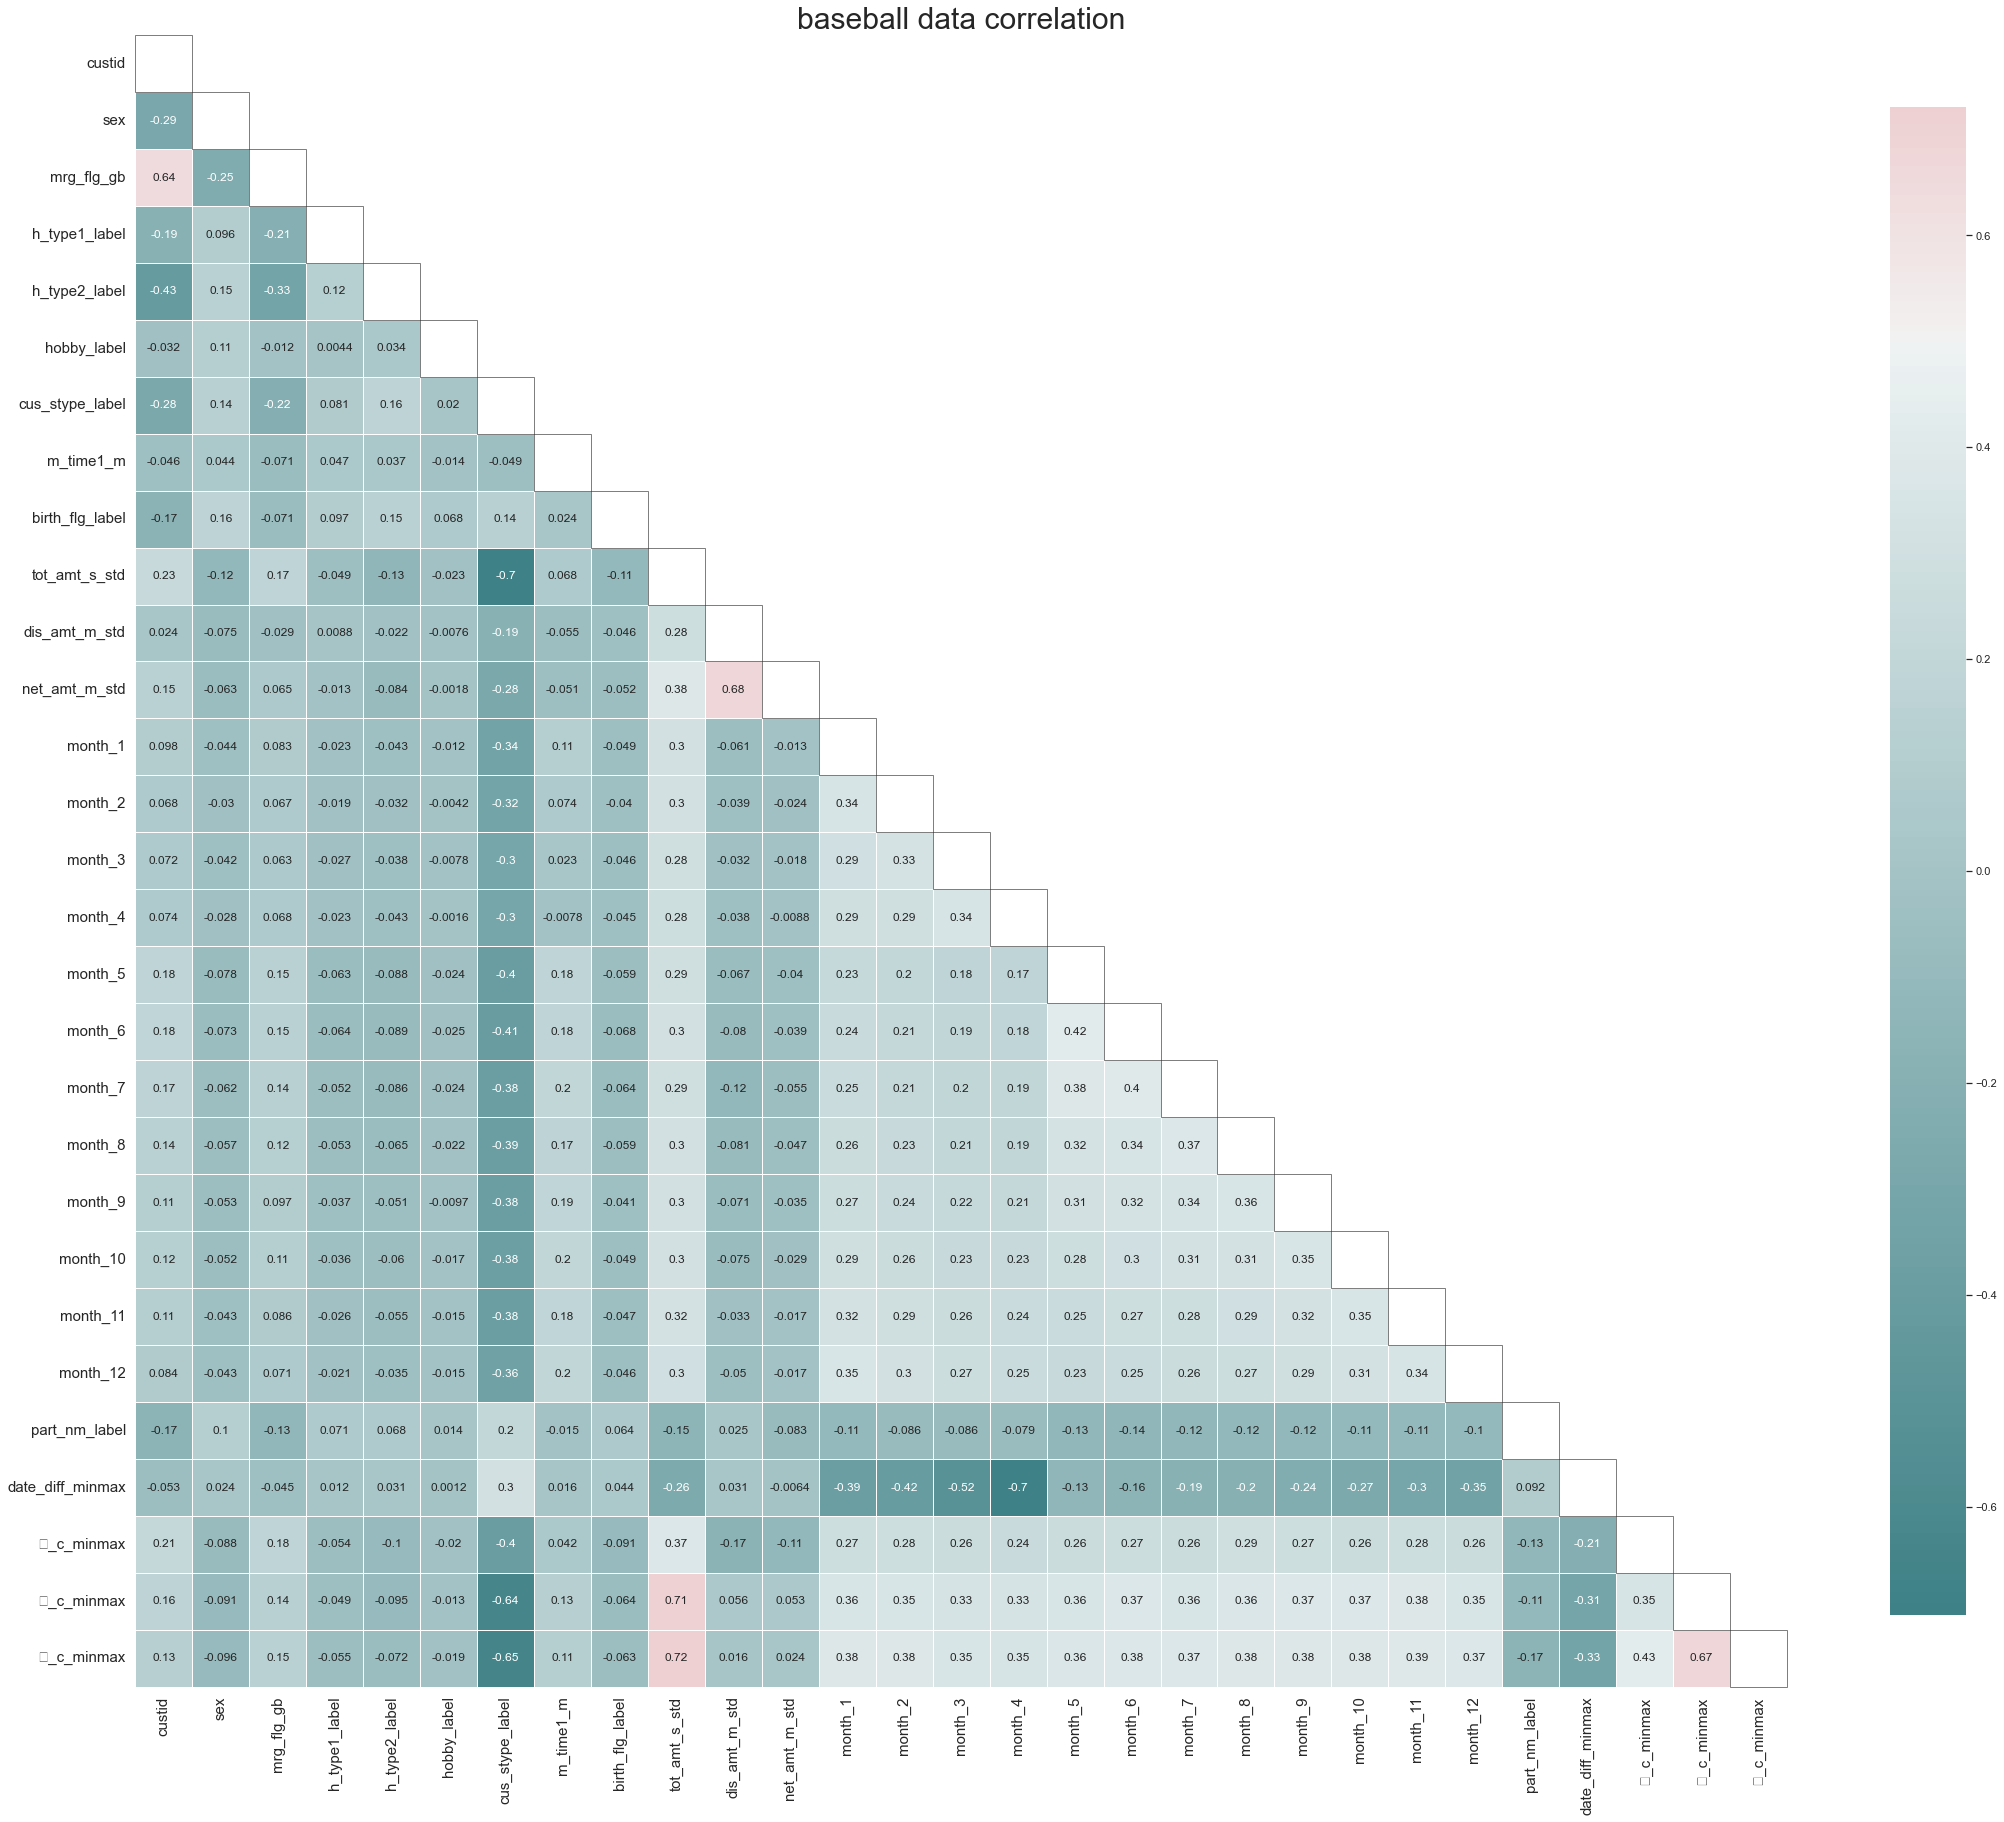

In [560]:
# 그래프로 그려보기
from matplotlib.patches import Rectangle

sns.set(style="white")

cor = result_a.corr()

f, ax = plt.subplots(figsize=(37, 37))
cmap = sns.diverging_palette(200, 10, as_cmap=True)

mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cor, mask=mask, cmap=cmap, center=0.5, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True)

plt.title('baseball data correlation', size=30)
ax.set_xticklabels(list(result_a.columns), size=15, rotation=90)
ax.set_yticklabels(list(result_a.columns), size=15, rotation=0)

for temp_num in range(len(result_a.columns)):
    ax.add_patch(Rectangle((temp_num, temp_num), 1, 1, fill=False,
                 edgecolor='black', lw=1, clip_on=False, alpha=0.5))

In [ ]:
# !pip install statsmodels

In [575]:
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,20.39,m_time1_m
1,15.21,cus_stype_label
2,14.22,sex
3,5.90,hobby_label
4,5.45,잡_c_minmax
5,5.06,month_4
6,4.74,custid
7,4.73,h_type2_label
8,4.54,의_c_minmax
9,4.27,birth_flg_label


In [576]:
def vif(x):
    # vif 10 초과시 drop을 위한 임계값 설정
    thresh = 10
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [577]:
vif(X)

1번째 VIF 측정
Max VIF feature & value : m_time1_m, 20.388613110805846
2번째 VIF 측정
Max VIF feature & value : sex, 13.846431397972944
3번째 VIF 측정
Max VIF feature & value : hobby_label, 11.987572606736542
4번째 VIF 측정
Max VIF feature & value : h_type2_label, 5.422588645279303


custid의 vif는 4.39입니다.
h_type1_label의 vif는 2.77입니다.
h_type2_label의 vif는 4.27입니다.
hobby_label의 vif는 5.42입니다.
birth_flg_label의 vif는 4.01입니다.
tot_amt_s_std의 vif는 3.81입니다.
dis_amt_m_std의 vif는 1.95입니다.
net_amt_m_std의 vif는 2.32입니다.
month_1의 vif는 3.24입니다.
month_2의 vif는 2.96입니다.
month_3의 vif는 3.32입니다.
month_4의 vif는 4.64입니다.
month_5의 vif는 3.26입니다.
month_6의 vif는 3.44입니다.
month_7의 vif는 3.62입니다.
month_8의 vif는 2.94입니다.
month_9의 vif는 3.2입니다.
month_10의 vif는 3.42입니다.
month_11의 vif는 3.06입니다.
month_12의 vif는 3.48입니다.
part_nm_label의 vif는 3.71입니다.
date_diff_minmax의 vif는 3.02입니다.
식_c_minmax의 vif는 1.72입니다.
의_c_minmax의 vif는 4.44입니다.
잡_c_minmax의 vif는 5.39입니다.


,custid,h_type1_label,h_type2_label,hobby_label,birth_flg_label,tot_amt_s_std,dis_amt_m_std,net_amt_m_std,month_1,month_2,...,month_8,month_9,month_10,month_11,month_12,part_nm_label,date_diff_minmax,식_c_minmax,의_c_minmax,잡_c_minmax
0,1.00,1.00,1.00,16.00,0.00,0.08,-0.75,-0.58,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.11,0.09,0.07
1,2.00,4.00,1.00,16.00,0.00,-0.25,-0.26,-0.29,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,27.00,0.05,0.01,0.03,0.06
2,3.00,1.00,2.00,16.00,0.00,0.60,-0.65,-0.05,1.00,0.00,...,1.00,0.00,1.00,0.00,1.00,1.00,0.01,0.01,0.03,0.16
3,4.00,4.00,4.00,10.00,1.00,-0.59,0.26,-0.41,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,12.00,0.04,0.00,0.00,0.02
4,5.00,7.00,3.00,16.00,1.00,-0.63,0.17,-0.70,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,28.00,0.01,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,49996.00,4.00,1.00,16.00,2.00,18.76,2.84,5.48,1.00,1.00,...,1.00,1.00,1.00,0.00,1.00,12.00,0.00,0.35,0.02,0.17
49991,49997.00,5.00,1.00,16.00,1.00,0.98,0.56,0.92,1.00,0.00,...,1.00,1.00,1.00,1.00,0.00,11.00,0.01,0.01,0.08,0.08
49992,49998.00,7.00,3.00,16.00,1.00,-0.31,-0.63,-0.59,1.00,0.00,...,1.00,1.00,0.00,1.00,1.00,22.00,0.03,0.04,0.05,0.05
49993,49999.00,1.00,4.00,1.00,1.00,-0.06,1.20,0.26,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,8.00,0.01,0.03,0.02,0.03


In [61]:
# VIF - 다중 공선성 15 이상인 m_time1_m 삭제
X1 = X.drop(['m_time1_m','custid'], axis=1)

### 모델링

- 이진분류
- 분류모델 + Rogistic regression

In [62]:
from sklearn.model_selection import train_test_split 

from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from sklearn.linear_model import LogisticRegression as LR

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [63]:
X_train,X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (39996, 27)
X_test shape: (9999, 27)
y_train shape: (39996,)
y_test shape: (9999,)


In [64]:
# 평가 함수
def scores(y_test,pred):
    #f1스코어
    print("f1스코어 : ",f1_score(y_test, pred))
    # 정확도
    print("정확도 : ",accuracy_score(y_test, pred))
    # 정밀도 
    print("정밀도 : ",precision_score(y_test, pred))
    # 재현율
    print("재현율 : ",recall_score(y_test, pred))

##### 1) DecisionTreeClassifier

In [82]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 5, 8]
}

clf = DTC(splitter='best')

grid_dclf = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도:', grid_dclf.best_score_)

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.789303766095762


In [83]:
best_dclf = grid_dclf.best_estimator_
preds = best_dclf.predict(X_test)

scores(y_test, preds)

f1스코어 :  0.8169784680550654
정확도 :  0.7925792579257925
정밀도 :  0.7946781115879828
재현율 :  0.8405665516615217


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


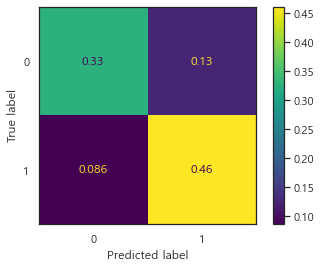

In [611]:
plot_confusion_matrix(best_dclf,X_test, y_test, normalize='all')
# 1 은 기혼

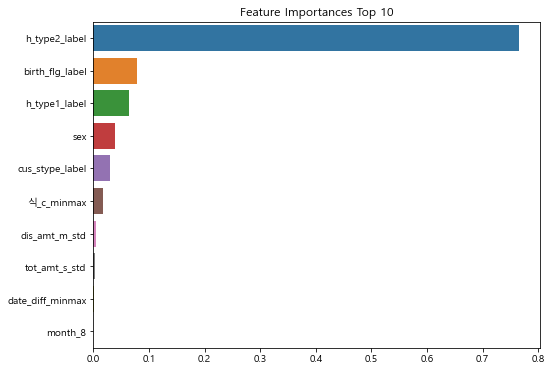

In [84]:
# Feature Importance
feature_importance_values = best_dclf.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top10 = feature_importances.sort_values(ascending=False)[:10]
 
plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 10')
sns.barplot(x=feature_top10, y=feature_top10.index)
plt.show()


In [ ]:
# !pip install pydotplus

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image # CART Tree 그림
import pydotplus
import os
 
os.environ['PATH'] += os.pathsep + 'c:/users/user/appdata/local/programs/python/python38/lib' # 경로지정
 
import numpy as np
feature_names = X_train.columns.tolist()
target_name = np.array(['1', '0'])
 
dot_data = export_graphviz(best_dclf,
                          filled = True,
                          rounded = True,
                          class_names = target_name,
                          feature_names = feature_names,
                          out_file = None)
 
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png') #Tree 이미지를 저장
 
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())

In [631]:
li = list(best_dclf.classes_) 
a = []
for i in li:
   a.append(f'{i}')

a = np.array(a)

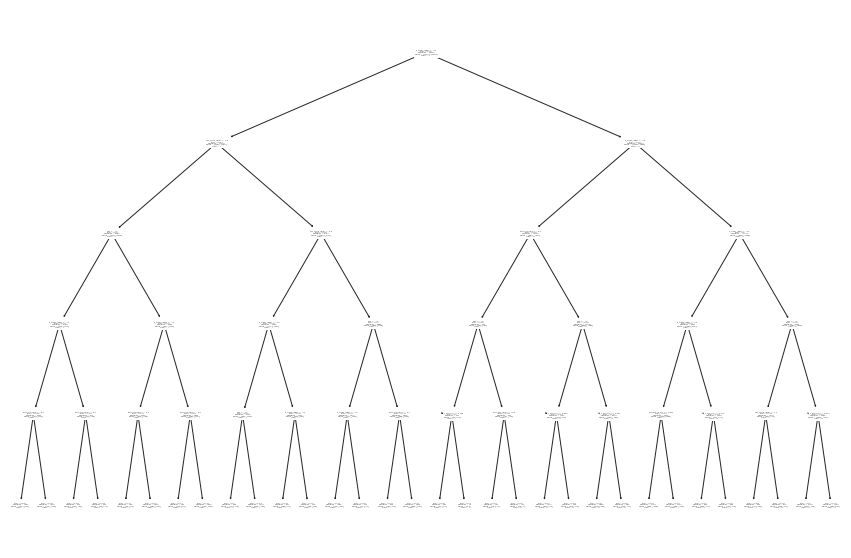

In [632]:
fig = plt.figure(figsize=(15, 10), facecolor='white')
plot_tree(best_dclf,
          feature_names=X_train.columns, ## 박스에 변수 이름 표시
          class_names=a, ## 클래스 이름(범주 이름)
         )
plt.show()

In [633]:
def get_info(dt_model, tree_type='clf'):
    tree = dt_model.tree_
    criterion = dt_model.get_params()['criterion'] 
    assert tree_type in ['clf', 'reg']
    num_node = tree.node_count
    info = []
    for i in range(num_node):
        temp_dict = dict()
        ## 각 정보들은 preorder 순서로 배열에 저장되어 있음.
        if tree.threshold[i] != -2: ## -2인 경우 끝마디이므로 질문이 없음
            split_feature = tree.feature[i]
            split_thres = tree.threshold[i]
            temp_dict['question'] = f'{split_feature} <= {split_thres:.3f}'
        
        impurity = tree.impurity[i] ## 불순도 값
        sample = tree.n_node_samples[i] ## 노드에 포함된 데이터 샘플 수
        value = tree.value[i]
        temp_dict['impurity'] = f'{criterion} = {impurity:.3f}' ## 불순도 측도, 불순도 값
        temp_dict['sample'] = sample
        temp_dict['value'] = value
        
        if tree_type == 'clf':
            classes = dt_model.classes_ ## 클래스 라벨
            idx = np.argmax(value) ## 예측라벨
            temp_dict['class'] = classes[idx]
        
        info.append(temp_dict)
        
    return info

In [634]:
get_info(best_dclf)

[{'question': '2 <= 2.500',
  'impurity': 'gini = 0.495',
  'sample': 39996,
  'value': array([[17994., 22002.]]),
  'class': 1},
 {'question': '4 <= 7.500',
  'impurity': 'gini = 0.301',
  'sample': 17923,
  'value': array([[ 3306., 14617.]]),
  'class': 1},
 {'question': '0 <= 1.500',
  'impurity': 'gini = 0.230',
  'sample': 9769,
  'value': array([[1293., 8476.]]),
  'class': 1},
 {'question': '2 <= 1.500',
  'impurity': 'gini = 0.162',
  'sample': 4184,
  'value': array([[ 372., 3812.]]),
  'class': 1},
 {'question': '5 <= 0.500',
  'impurity': 'gini = 0.105',
  'sample': 3572,
  'value': array([[ 199., 3373.]]),
  'class': 1},
 {'impurity': 'gini = 0.029',
  'sample': 1657,
  'value': array([[  24., 1633.]]),
  'class': 1},
 {'impurity': 'gini = 0.166',
  'sample': 1915,
  'value': array([[ 175., 1740.]]),
  'class': 1},
 {'question': '5 <= 0.500',
  'impurity': 'gini = 0.406',
  'sample': 612,
  'value': array([[173., 439.]]),
  'class': 1},
 {'impurity': 'gini = 0.489',
  'samp

##### 2) RandomForest

In [635]:
# 모델 학습
rdlf = RFC(n_estimators=5, random_state=0)
rdlf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [640]:
pred = rdlf.predict(X_test)
scores(y_test,pred)

f1스코어 :  0.77561282212445
정확도 :  0.7500750075007501
정밀도 :  0.7630742049469965
재현율 :  0.7885703852473982


In [655]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RFC(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.7979


In [656]:
best_rclf = grid_cv.best_estimator_
preds = best_dclf.predict(X_test)

scores(y_test, preds)

f1스코어 :  0.8136848602416014
정확도 :  0.7886788678867886
정밀도 :  0.7868349249658936
재현율 :  0.8424319883147708


In [657]:
def graph_generator(model,importances, X):
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    df_rf_impt = pd.Series(importances, index=X.columns)
    df_rf_impt = df_rf_impt.sort_values(ascending=False)

    for f in range(X.shape[1]):
        print("%s : feature %d (%f)" % ( df_rf_impt.index[f], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
h_type2_label : feature 2 (0.488337)
sex : feature 0 (0.078030)
h_type1_label : feature 1 (0.059602)
birth_flg_label : feature 5 (0.059377)
cus_stype_label : feature 4 (0.058311)
식_c_minmax : feature 23 (0.046135)
dis_amt_m_std : feature 7 (0.036020)
tot_amt_s_std : feature 6 (0.032158)
net_amt_m_std : feature 8 (0.024445)
part_nm_label : feature 21 (0.023939)
잡_c_minmax : feature 25 (0.018546)
date_diff_minmax : feature 22 (0.017049)
의_c_minmax : feature 24 (0.015018)
month_6 : feature 14 (0.008486)
month_5 : feature 13 (0.006231)
hobby_label : feature 3 (0.004546)
month_7 : feature 15 (0.003730)
month_10 : feature 18 (0.002603)
month_9 : feature 17 (0.002489)
month_8 : feature 16 (0.002487)
month_12 : feature 20 (0.002341)
month_3 : feature 11 (0.002221)
month_2 : feature 10 (0.002177)
month_11 : feature 19 (0.002032)
month_1 : feature 9 (0.002020)
month_4 : feature 12 (0.001671)


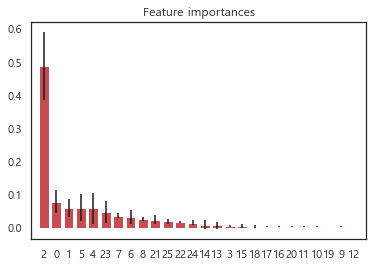

In [659]:
rf_impt = best_rclf.feature_importances_
graph_generator(best_rclf, rf_impt, X_train)

#### 3) GradientBoostingClassifier


In [660]:
gdlf = GBC()
gdlf.fit(X_train, y_train)

GradientBoostingClassifier()

In [661]:
params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gdlf, param_grid=params, cv=3, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.8038


In [701]:
best_gclf = grid_cv.best_estimator_
preds = best_gclf.predict(X_test)

scores(y_test, preds)

f1스코어 :  0.8247640885439633
정확도 :  0.8012801280128012
정밀도 :  0.7976799727055612
재현율 :  0.8537520540441847


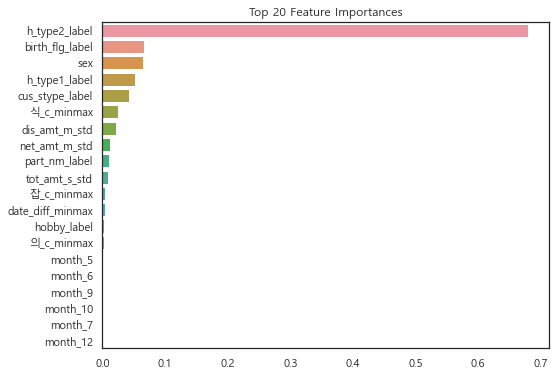

In [702]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = best_gclf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

#### 4) 로지스틱회귀

In [715]:
rlclf = LR(C=1, max_iter=10000)
rlclf.fit(X_train, y_train)
preds = rlclf.predict(X_test)
scores(y_test, preds)

f1스코어 :  0.7443289652056032
정확도 :  0.7170717071707171
정밀도 :  0.7369362920544023
재현율 :  0.7518714624794596


In [751]:
rlclf2 = LR(C = 1.0, random_state = 0)  
# C속성 : 분류정확도를 조절하기 위해 모델에 패널티를 적용(L2정규화)-과적합 방지
rlclf2.fit(X_train, y_train)  # 지도학습이니까
y_pred = rlclf2.predict(X_test) 
scores(y_test, y_pred) 

f1스코어 :  0.74032751484614
정확도 :  0.7113711371137114
정밀도 :  0.7298208266808586
재현율 :  0.7511411356582071


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [752]:
# 파라메터 후보
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

rlclf = LR(max_iter=1000)
# 그리드 서치 진행
grid_search = GridSearchCV(rlclf, param_grid, cv=5)        
grid_search.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_search.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_search.best_score_))

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\User\AppData\Local\Programs\Python\Pyth

최적 하이퍼 파라미터:
 {'C': 1000.0, 'penalty': 'l2'}
최고 예측 정확도: 0.7176


In [754]:
best_rlclf = grid_search.best_estimator_
preds = best_rlclf.predict(X_test)

scores(y_test, preds)

f1스코어 :  0.7440681036044194
정확도 :  0.7173717371737174
정밀도 :  0.7381850853548967
재현율 :  0.7500456454263282


In [ ]:
plt.plot(X_train[y_test==0][:,0],X_train[y_test==0][:,1], 'r1')
plt.plot(X_train[y_test==1][:,0],X_train[y_test==1][:,1], 'b1')

plt.plot(X_test[preds==0][:,0],X_test[preds==0][:,1], 'rs', alpha=0.3)
plt.plot(X_test[preds==1][:,0],X_testx[preds==1][:,1], 'bs', alpha=0.3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

TN, FP, FN, TP = cm.ravel()

In [760]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 사이킷런의 파이프라인 라이브러리를 통해서 데이터 스케일과 모델 적합을 한번에 할 수 있음.
svm_clf = Pipeline([("polynomial",PolynomialFeatures(degree=3)),
                    ('scaler',StandardScaler()),
                    ("svm",LinearSVC(C=10,loss='hinge'))
])
# 모델 훈련
svm_clf.fit(X_train,y_train)
preds = svm_clf.predict(X_test)

scores(y_test, preds)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


f1스코어 :  0.642092296029565
정확도 :  0.6222622262226223
정밀도 :  0.6674546887312844
재현율 :  0.6185868176008764


#### 5) XGBoost 

In [ ]:
# !pip install xgboost

In [73]:
X1 = X1.astype('float')

In [74]:
X_train,X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (39996, 26)
X_test shape: (9999, 26)
y_train shape: (39996,)
y_test shape: (9999,)


In [75]:
import xgboost as xgb

# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


In [77]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [80]:
y_pre_probs = xg_clf.predict(X_test)

In [81]:
scores(y_test, y_pre_probs) 

f1스코어 :  0.8260600159334337
정확도 :  0.8034803480348035
정밀도 :  0.8058721934369603
재현율 :  0.8472852732885419
